In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import re
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import time
import os
import json
from tqdm import tqdm

In [18]:
torch.manual_seed(42)
np.random.seed(42)

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# ========== 1. MODEL DEFINITIONS ==========


In [20]:
class RNNOneHot(nn.Module):
    """Simple RNN model using one-hot encoding"""
    def __init__(self, vocab_size, hidden_size, num_layers, dropout=0.2):
        super(RNNOneHot, self).__init__()
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.rnn = nn.RNN(vocab_size, hidden_size, num_layers,
                         batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, hidden=None):
        # Convert indices to one-hot vectors
        batch_size, seq_len = x.size()
        one_hot = torch.zeros(batch_size, seq_len, self.vocab_size, device=device)
        one_hot.scatter_(2, x.unsqueeze(2), 1)

        # Initialize hidden state if not provided
        if hidden is None:
            hidden = self.init_hidden(batch_size)

        out, hidden = self.rnn(one_hot, hidden)
        out = self.dropout(out)
        out = self.fc(out)
        return out, hidden

    def init_hidden(self, batch_size):
        return torch.zeros(self.num_layers, batch_size, self.hidden_size, device=device)

class RNNEmbedding(nn.Module):
    """RNN model using word embeddings"""
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers, dropout=0.2):
        super(RNNEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.RNN(embed_size, hidden_size, num_layers,
                         batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, vocab_size)
        self.hidden_size = hidden_size
        self.num_layers = num_layers

    def forward(self, x, hidden=None):
        # Initialize hidden state if not provided
        if hidden is None:
            hidden = self.init_hidden(x.size(0))

        x = self.embedding(x)
        x = self.dropout(x)
        out, hidden = self.rnn(x, hidden)
        out = self.dropout(out)
        out = self.fc(out)
        return out, hidden

    def init_hidden(self, batch_size):
        return torch.zeros(self.num_layers, batch_size, self.hidden_size, device=device)


class LSTMOneHot(nn.Module):
    """LSTM model using one-hot encoding"""
    def __init__(self, vocab_size, hidden_size, num_layers, dropout=0.2):
        super(LSTMOneHot, self).__init__()
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(vocab_size, hidden_size, num_layers,
                           batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, hidden=None):
        # Convert indices to one-hot vectors
        batch_size, seq_len = x.size()
        one_hot = torch.zeros(batch_size, seq_len, self.vocab_size, device=device)
        one_hot.scatter_(2, x.unsqueeze(2), 1)

        # Initialize hidden state if not provided
        if hidden is None:
            hidden = self.init_hidden(batch_size)

        out, hidden = self.lstm(one_hot, hidden)
        out = self.dropout(out)
        out = self.fc(out)
        return out, hidden

    def init_hidden(self, batch_size):
        return (torch.zeros(self.num_layers, batch_size, self.hidden_size, device=device),
                torch.zeros(self.num_layers, batch_size, self.hidden_size, device=device))


class LSTMEmbedding(nn.Module):
    """LSTM model using word embeddings"""
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers, dropout=0.2):
        super(LSTMEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers,
                           batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, vocab_size)
        self.hidden_size = hidden_size
        self.num_layers = num_layers

    def forward(self, x, hidden=None):
        # Initialize hidden state if not provided
        if hidden is None:
            hidden = self.init_hidden(x.size(0))

        x = self.embedding(x)
        x = self.dropout(x)
        out, hidden = self.lstm(x, hidden)
        out = self.dropout(out)
        out = self.fc(out)
        return out, hidden

    def init_hidden(self, batch_size):
        return (torch.zeros(self.num_layers, batch_size, self.hidden_size, device=device),
                torch.zeros(self.num_layers, batch_size, self.hidden_size, device=device))


class GRUOneHot(nn.Module):
    """GRU model using one-hot encoding"""
    def __init__(self, vocab_size, hidden_size, num_layers, dropout=0.2):
        super(GRUOneHot, self).__init__()
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.gru = nn.GRU(vocab_size, hidden_size, num_layers,
                         batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, hidden=None):
        # Convert indices to one-hot vectors
        batch_size, seq_len = x.size()
        one_hot = torch.zeros(batch_size, seq_len, self.vocab_size, device=device)
        one_hot.scatter_(2, x.unsqueeze(2), 1)

        # Initialize hidden state if not provided
        if hidden is None:
            hidden = self.init_hidden(batch_size)

        out, hidden = self.gru(one_hot, hidden)
        out = self.dropout(out)
        out = self.fc(out)
        return out, hidden

    def init_hidden(self, batch_size):
        return torch.zeros(self.num_layers, batch_size, self.hidden_size, device=device)


class GRUEmbedding(nn.Module):
    """GRU model using word embeddings"""
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers, dropout=0.2):
        super(GRUEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.gru = nn.GRU(embed_size, hidden_size, num_layers,
                         batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, vocab_size)
        self.hidden_size = hidden_size
        self.num_layers = num_layers

    def forward(self, x, hidden=None):
        # Initialize hidden state if not provided
        if hidden is None:
            hidden = self.init_hidden(x.size(0))

        x = self.embedding(x)
        x = self.dropout(x)
        out, hidden = self.gru(x, hidden)
        out = self.dropout(out)
        out = self.fc(out)
        return out, hidden

    def init_hidden(self, batch_size):
        return torch.zeros(self.num_layers, batch_size, self.hidden_size, device=device)

# ========== 2. DATA PROCESSING ==========

In [21]:
def preprocess_text(text):
    """Preprocess text with better tokenization and handling of special characters"""
    # Convert to lowercase
    text = text.lower()

    # Preserve line breaks for poetry structure
    text = text.replace('\n', ' <linebreak> ')

    # Separate punctuation from words but keep it
    text = re.sub(r'([.,!?;:])', r' \1 ', text)

    # Remove other special characters
    text = re.sub(r'[^a-zA-Z0-9\s.,!?;:<>]', '', text)

    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()

    # Tokenize
    return text.split()

def create_vocab(tokens_list, min_freq=2):
    """Create vocabulary with special tokens and frequency threshold"""
    word_freq = {}
    for tokens in tokens_list:
        for word in tokens:
            word_freq[word] = word_freq.get(word, 0) + 1

    # Filter words by frequency
    special_tokens = ['<pad>', '<unk>', '<sos>', '<eos>']
    words = special_tokens + [word for word, freq in word_freq.items() if freq >= min_freq]

    # Create mappings
    word_to_idx = {word: idx for idx, word in enumerate(words)}
    idx_to_word = {idx: word for word, idx in word_to_idx.items()}

    return word_to_idx, idx_to_word

def create_sequences(tokens, word_to_idx, seq_length):
    """Create input-target pairs for training"""
    pad_idx = word_to_idx['<pad>']
    unk_idx = word_to_idx['<unk>']

    input_seqs, target_seqs = [], []

    # Use sliding window approach for more training data
    for i in range(0, len(tokens) - seq_length, 1):
        # Input sequence
        input_seq = [word_to_idx.get(t, unk_idx) for t in tokens[i:i+seq_length]]

        # Target is the next word after each position in the input sequence
        target_seq = [word_to_idx.get(tokens[min(i+j+1, len(tokens)-1)], unk_idx) for j in range(seq_length)]

        input_seqs.append(input_seq)
        target_seqs.append(target_seq)

    return input_seqs, target_seqs

In [22]:
class PoemDataset(Dataset):
    """PyTorch Dataset for poem data"""
    def __init__(self, inputs, targets):
        self.inputs = inputs
        self.targets = targets

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx]

# ========== 3. TRAINING AND EVALUATION ==========


In [23]:
def train_epoch(model, dataloader, criterion, optimizer, clip_grad=5.0):
    """Train for one epoch"""
    model.train()
    epoch_loss = 0

    # Track progress with tqdm
    progress_bar = tqdm(dataloader, desc="Training")

    for inputs, targets in progress_bar:
        inputs, targets = inputs.to(device), targets.to(device)

        # Initialize hidden state
        hidden = model.init_hidden(inputs.size(0))

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs, _ = model(inputs, hidden)

        # Reshape for loss calculation
        outputs = outputs.view(-1, outputs.size(-1))
        targets = targets.view(-1)

        # Calculate loss
        loss = criterion(outputs, targets)

        # Backward pass
        loss.backward()

        # Gradient clipping to prevent exploding gradients
        nn.utils.clip_grad_norm_(model.parameters(), clip_grad)

        # Update parameters
        optimizer.step()

        # Accumulate loss
        epoch_loss += loss.item()

        # Update progress bar
        progress_bar.set_postfix({"loss": f"{loss.item():.4f}"})

    return epoch_loss / len(dataloader)

In [24]:
def evaluate(model, dataloader, criterion):
    """Evaluate the model"""
    model.eval()
    total_loss = 0
    perplexity = 0

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)

            # Initialize hidden state
            hidden = model.init_hidden(inputs.size(0))

            # Forward pass
            outputs, _ = model(inputs, hidden)

            # Reshape for loss calculation
            outputs = outputs.view(-1, outputs.size(-1))
            targets = targets.view(-1)

            # Calculate loss
            loss = criterion(outputs, targets)
            total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    perplexity = np.exp(avg_loss)

    return avg_loss, perplexity

In [25]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, model_name,
               scheduler=None, patience=5, clip_grad=5.0):
    """Train the model with early stopping and logging"""
    # Create directory for model artifacts
    os.makedirs("model_results", exist_ok=True)

    train_losses = []
    val_losses = []
    perplexities = []
    best_val_loss = float('inf')
    best_epoch = 0
    patience_counter = 0

    start_time = time.time()

    for epoch in range(num_epochs):
        # Train for one epoch
        train_loss = train_epoch(model, train_loader, criterion, optimizer, clip_grad)
        train_losses.append(train_loss)

        # Evaluate on validation set
        val_loss, perplexity = evaluate(model, val_loader, criterion)
        val_losses.append(val_loss)
        perplexities.append(perplexity)

        # Print epoch results
        print(f"Epoch {epoch+1}/{num_epochs}, "
              f"Train Loss: {train_loss:.4f}, "
              f"Val Loss: {val_loss:.4f}, "
              f"Perplexity: {perplexity:.2f}")

        # Learning rate scheduling
        if scheduler:
            if isinstance(scheduler, optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(val_loss)
            else:
                scheduler.step()

        # Save checkpoint if this is the best model so far
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch = epoch
            patience_counter = 0

            # Save the model
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': val_loss,
                'train_loss': train_loss,
                'perplexity': perplexity
            }, f"model_results/{model_name}_best.pt")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    end_time = time.time()
    training_time = end_time - start_time

    # Save training history
    history = {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'perplexities': perplexities,
        'best_epoch': best_epoch,
        'best_val_loss': best_val_loss,
        'training_time': training_time
    }

    with open(f"model_results/{model_name}_history.json", 'w') as f:
        json.dump(history, f)

    # Plot and save training curves
    plt.figure(figsize=(12, 5))

    # Loss subplot
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f'{model_name} - Loss Curves')

    # Perplexity subplot
    plt.subplot(1, 2, 2)
    plt.plot(perplexities, label='Validation Perplexity', color='green')
    plt.xlabel('Epochs')
    plt.ylabel('Perplexity')
    plt.legend()
    plt.title(f'{model_name} - Perplexity')

    plt.tight_layout()
    plt.savefig(f"model_results/{model_name}_training_curves.png")

    return history

# ========== 4. TEXT GENERATION ==========


In [26]:
def temperature_sampling(probs, temperature=1.0, top_k=None, top_p=None):
    """Advanced sampling techniques for text generation"""
    # Apply temperature
    if temperature != 1.0:
        probs = probs.pow(1.0 / temperature)

    # Top-k sampling
    if top_k is not None:
        top_k = min(top_k, probs.size(-1))
        values, indices = torch.topk(probs, top_k)
        zeroed_probs = torch.zeros_like(probs)
        zeroed_probs.scatter_(0, indices, values)
        probs = zeroed_probs

    # Nucleus (top-p) sampling
    if top_p is not None and top_p < 1.0:
        sorted_probs, sorted_indices = torch.sort(probs, descending=True)
        cumulative_probs = torch.cumsum(sorted_probs, dim=0)

        # Remove tokens with cumulative probability above the threshold
        sorted_indices_to_remove = cumulative_probs > top_p
        # Shift the indices to the right to keep the first token above the threshold
        sorted_indices_to_remove[1:] = sorted_indices_to_remove[:-1].clone()
        sorted_indices_to_remove[0] = 0

        indices_to_remove = sorted_indices[sorted_indices_to_remove]
        probs[indices_to_remove] = 0.0

    # Normalize the probabilities
    probs = probs / probs.sum()

    # Sample from the distribution
    next_token = torch.multinomial(probs, 1).item()

    return next_token

def generate_poem(model, word_to_idx, idx_to_word, start_words, length=50,
                 temperature=0.8, top_k=5, top_p=0.9):
    """Generate poem text using the trained model"""
    model.eval()

    # Convert start words to indices
    unk_idx = word_to_idx.get('<unk>', 0)
    current_indices = [word_to_idx.get(word.lower(), unk_idx) for word in start_words]

    # Pad the sequence to the expected input length
    seq_length = model.hidden_size // 2  # Estimate sequence length based on model

    # Ensure we have the right number of tokens
    if len(current_indices) < seq_length:
        current_indices = [unk_idx] * (seq_length - len(current_indices)) + current_indices
    else:
        current_indices = current_indices[-seq_length:]

    # Initialize result with capitalized start words
    result = [word.capitalize() for word in start_words]

    # Initialize hidden state
    hidden = model.init_hidden(1)

    # Generate words
    for _ in range(length - len(start_words)):
        # Convert current indices to tensor
        input_tensor = torch.tensor([current_indices], dtype=torch.long).to(device)

        # Forward pass
        with torch.no_grad():
            output, hidden = model(input_tensor, hidden)

        # Get next word probabilities (last position in sequence)
        word_probs = F.softmax(output[0, -1], dim=-1)

        # Sample next word
        next_idx = temperature_sampling(word_probs, temperature, top_k, top_p)
        next_word = idx_to_word.get(next_idx, "<unk>")

        # Skip special tokens
        if next_word in ["<pad>", "<unk>", "<sos>", "<eos>"]:
            continue

        # Handle line breaks
        if next_word == "<linebreak>":
            result.append("\n")
        else:
            result.append(next_word)

        # Update current indices (shift and add new word)
        current_indices = current_indices[1:] + [next_idx]

        # Add periodic line breaks for structure if not already added
        if next_word != "<linebreak>" and len(result) % 8 == 0 and result[-1] not in [".", ",", "!", "?"]:
            result.append("\n")

    # Post-process the poem
    poem = " ".join(result)
    poem = re.sub(r"\s+([.,!?])", r"\1", poem)  # Fix spacing with punctuation
    poem = re.sub(r"\s*\n\s*", "\n", poem)  # Fix spacing around line breaks

    return poem

# ========== 5. MODEL COMPARISON AND EVALUATION ==========

In [35]:
def evaluate_all_models(models, test_loader, criterion):
    """Evaluate and compare all models"""
    results = {}

    for name, model in models.items():
        print(f"Evaluating {name}...")
        model.eval()

        # Load the best model weights
        checkpoint = torch.load(f"model_results/{name}_best.pt",
                                map_location=device,
                                weights_only=False, # set to False to allow arbitrary code execution
                                )
        model.load_state_dict(checkpoint['model_state_dict'])

        # Calculate word prediction accuracy
        correct = 0
        total = 0

        # Calculate test loss and perplexity  # Added this block
        test_loss = 0
        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                hidden = model.init_hidden(inputs.size(0))
                outputs, _ = model(inputs, hidden)
                outputs = outputs.view(-1, outputs.size(-1))
                targets = targets.view(-1)
                loss = criterion(outputs, targets)
                test_loss += loss.item()

        test_loss /= len(test_loader) #Averaging the loss
        perplexity = np.exp(test_loss)


        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs, targets = inputs.to(device), targets.to(device)

                # Initialize hidden state
                hidden = model.init_hidden(inputs.size(0))

                # Forward pass
                outputs, _ = model(inputs, hidden)

                # Get predicted words
                _, predicted = torch.max(outputs, dim=2)

                # Mask out padding tokens
                mask = targets != word_to_idx['<pad>']

                # Count correct predictions
                correct += ((predicted == targets) & mask).sum().item()
                total += mask.sum().item()

        accuracy = correct / total if total > 0 else 0

        # Generate sample text
        sample_poem = generate_poem(
            model, word_to_idx, idx_to_word,
            ["love", "is"], length=30, temperature=0.8
        )

        # Store results
        results[name] = {
            'test_loss': test_loss,
            'perplexity': perplexity,
            'accuracy': accuracy,
            'sample': sample_poem
        }

        print(f"  Test Loss: {test_loss:.4f}")
        print(f"  Perplexity: {perplexity:.2f}")
        print(f"  Accuracy: {accuracy:.4f}")
        print(f"  Sample:\n{sample_poem}\n")

    # Save results to file
    with open("model_results/model_comparison.json", 'w') as f:
        # Convert values to serializable format
        serializable_results = {
            k: {sk: float(sv) if isinstance(sv, torch.Tensor) else sv
                for sk, sv in v.items()}
            for k, v in results.items()
        }
        json.dump(serializable_results, f, indent=2)

    # Create comparison visualizations
    metrics = ['test_loss', 'perplexity', 'accuracy']
    plt.figure(figsize=(15, 5))

    for i, metric in enumerate(metrics):
        plt.subplot(1, 3, i+1)
        values = [results[model][metric] for model in results]
        plt.bar(list(results.keys()), values)
        plt.title(f'Model Comparison - {metric.capitalize()}')
        plt.xticks(rotation=45)
        plt.tight_layout()

    plt.savefig("model_results/model_comparison.png")

    return results

# ========== 6. MAIN FUNCTION ==========

In [33]:
# Load dataset
dataset_path = "./poems-100.csv"
df = pd.read_csv(dataset_path)

# Preprocess texts
print("Preprocessing data...")
df["processed_text"] = df["text"].apply(preprocess_text)

# Create vocabulary
print("Creating vocabulary...")
word_to_idx, idx_to_word = create_vocab(df["processed_text"].tolist(), min_freq=2)
vocab_size = len(word_to_idx)
print(f"Vocabulary size: {vocab_size}")

# Create sequences
print("Creating sequences...")
sequence_length = 10  # Increased from original 5 for better context
all_inputs, all_targets = [], []

for tokens in df["processed_text"]:
    inputs, targets = create_sequences(tokens, word_to_idx, sequence_length)
    all_inputs.extend(inputs)
    all_targets.extend(targets)

# Convert to PyTorch tensors
all_inputs = torch.tensor(all_inputs, dtype=torch.long)
all_targets = torch.tensor(all_targets, dtype=torch.long)

# Split into train, validation, and test sets
train_inputs, temp_inputs, train_targets, temp_targets = train_test_split(
    all_inputs, all_targets, test_size=0.2, random_state=42)

val_inputs, test_inputs, val_targets, test_targets = train_test_split(
    temp_inputs, temp_targets, test_size=0.5, random_state=42)

# Create datasets and dataloaders
batch_size = 64
train_dataset = PoemDataset(train_inputs, train_targets)
val_dataset = PoemDataset(val_inputs, val_targets)
test_dataset = PoemDataset(test_inputs, test_targets)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Model hyperparameters
embed_size = 256
hidden_size = 512
num_layers = 2
dropout = 0.3


Preprocessing data...
Creating vocabulary...
Vocabulary size: 1880
Creating sequences...


Preprocessing data...
Creating vocabulary...
Vocabulary size: 1880
Creating sequences...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



===== Starting training for all models =====


===== Training RNN_OHE =====



Training: 100%|██████████| 385/385 [00:03<00:00, 124.45it/s, loss=4.4854]


Epoch 1/100, Train Loss: 5.1661, Val Loss: 4.8836, Perplexity: 132.11


Training: 100%|██████████| 385/385 [00:02<00:00, 146.79it/s, loss=3.7801]


Epoch 2/100, Train Loss: 4.3445, Val Loss: 3.8750, Perplexity: 48.18


Training: 100%|██████████| 385/385 [00:02<00:00, 147.47it/s, loss=3.6310]


Epoch 3/100, Train Loss: 3.5904, Val Loss: 3.3198, Perplexity: 27.65


Training: 100%|██████████| 385/385 [00:02<00:00, 146.13it/s, loss=3.2370]


Epoch 4/100, Train Loss: 3.0080, Val Loss: 2.8065, Perplexity: 16.55


Training: 100%|██████████| 385/385 [00:02<00:00, 133.32it/s, loss=2.4497]


Epoch 5/100, Train Loss: 2.5113, Val Loss: 2.3758, Perplexity: 10.76


Training: 100%|██████████| 385/385 [00:02<00:00, 141.36it/s, loss=1.9065]


Epoch 6/100, Train Loss: 2.1227, Val Loss: 2.0389, Perplexity: 7.68


Training: 100%|██████████| 385/385 [00:02<00:00, 144.01it/s, loss=1.3733]


Epoch 7/100, Train Loss: 1.8341, Val Loss: 1.7799, Perplexity: 5.93


Training: 100%|██████████| 385/385 [00:03<00:00, 123.76it/s, loss=1.7613]


Epoch 8/100, Train Loss: 1.6415, Val Loss: 1.6052, Perplexity: 4.98


Training: 100%|██████████| 385/385 [00:02<00:00, 139.64it/s, loss=1.5655]


Epoch 9/100, Train Loss: 1.5002, Val Loss: 1.4987, Perplexity: 4.48


Training: 100%|██████████| 385/385 [00:03<00:00, 121.04it/s, loss=1.1750]


Epoch 10/100, Train Loss: 1.4045, Val Loss: 1.3990, Perplexity: 4.05


Training: 100%|██████████| 385/385 [00:02<00:00, 143.91it/s, loss=1.2111]


Epoch 11/100, Train Loss: 1.3339, Val Loss: 1.3539, Perplexity: 3.87


Training: 100%|██████████| 385/385 [00:02<00:00, 145.10it/s, loss=1.4678]


Epoch 12/100, Train Loss: 1.2858, Val Loss: 1.3183, Perplexity: 3.74


Training: 100%|██████████| 385/385 [00:02<00:00, 136.97it/s, loss=1.3008]


Epoch 13/100, Train Loss: 1.2412, Val Loss: 1.2613, Perplexity: 3.53


Training: 100%|██████████| 385/385 [00:02<00:00, 133.90it/s, loss=0.9593]


Epoch 14/100, Train Loss: 1.2079, Val Loss: 1.2473, Perplexity: 3.48


Training: 100%|██████████| 385/385 [00:03<00:00, 122.22it/s, loss=1.0641]


Epoch 15/100, Train Loss: 1.1836, Val Loss: 1.2349, Perplexity: 3.44


Training: 100%|██████████| 385/385 [00:03<00:00, 117.61it/s, loss=1.1744]


Epoch 16/100, Train Loss: 1.1640, Val Loss: 1.1991, Perplexity: 3.32


Training: 100%|██████████| 385/385 [00:06<00:00, 62.63it/s, loss=1.1757]


Epoch 17/100, Train Loss: 1.1435, Val Loss: 1.1911, Perplexity: 3.29


Training: 100%|██████████| 385/385 [00:04<00:00, 87.61it/s, loss=1.1814]


Epoch 18/100, Train Loss: 1.1324, Val Loss: 1.1780, Perplexity: 3.25


Training: 100%|██████████| 385/385 [00:04<00:00, 90.63it/s, loss=1.1943] 


Epoch 19/100, Train Loss: 1.1160, Val Loss: 1.1837, Perplexity: 3.27


Training: 100%|██████████| 385/385 [00:03<00:00, 127.88it/s, loss=1.3041]


Epoch 20/100, Train Loss: 1.1046, Val Loss: 1.1599, Perplexity: 3.19


Training: 100%|██████████| 385/385 [00:02<00:00, 146.12it/s, loss=1.1794]


Epoch 21/100, Train Loss: 1.0962, Val Loss: 1.1643, Perplexity: 3.20


Training: 100%|██████████| 385/385 [00:03<00:00, 122.60it/s, loss=0.9866]


Epoch 22/100, Train Loss: 1.0872, Val Loss: 1.1578, Perplexity: 3.18


Training: 100%|██████████| 385/385 [00:02<00:00, 145.55it/s, loss=1.0832]


Epoch 23/100, Train Loss: 1.0781, Val Loss: 1.1455, Perplexity: 3.14


Training: 100%|██████████| 385/385 [00:02<00:00, 131.70it/s, loss=1.1848]


Epoch 24/100, Train Loss: 1.0703, Val Loss: 1.1407, Perplexity: 3.13


Training: 100%|██████████| 385/385 [00:02<00:00, 147.60it/s, loss=1.1616]


Epoch 25/100, Train Loss: 1.0649, Val Loss: 1.1436, Perplexity: 3.14


Training: 100%|██████████| 385/385 [00:02<00:00, 143.45it/s, loss=1.1222]


Epoch 26/100, Train Loss: 1.0586, Val Loss: 1.1256, Perplexity: 3.08


Training: 100%|██████████| 385/385 [00:02<00:00, 143.50it/s, loss=1.2336]


Epoch 27/100, Train Loss: 1.0502, Val Loss: 1.1272, Perplexity: 3.09


Training: 100%|██████████| 385/385 [00:02<00:00, 135.41it/s, loss=0.8742]


Epoch 28/100, Train Loss: 1.0468, Val Loss: 1.1196, Perplexity: 3.06


Training: 100%|██████████| 385/385 [00:02<00:00, 130.73it/s, loss=1.1780]


Epoch 29/100, Train Loss: 1.0386, Val Loss: 1.1339, Perplexity: 3.11


Training: 100%|██████████| 385/385 [00:02<00:00, 144.18it/s, loss=1.2225]


Epoch 30/100, Train Loss: 1.0348, Val Loss: 1.1161, Perplexity: 3.05


Training: 100%|██████████| 385/385 [00:02<00:00, 143.72it/s, loss=1.2302]


Epoch 31/100, Train Loss: 1.0299, Val Loss: 1.1252, Perplexity: 3.08


Training: 100%|██████████| 385/385 [00:02<00:00, 140.27it/s, loss=1.2847]


Epoch 32/100, Train Loss: 1.0278, Val Loss: 1.1098, Perplexity: 3.03


Training: 100%|██████████| 385/385 [00:02<00:00, 131.53it/s, loss=1.0960]


Epoch 33/100, Train Loss: 1.0244, Val Loss: 1.1192, Perplexity: 3.06


Training: 100%|██████████| 385/385 [00:02<00:00, 146.56it/s, loss=1.0689]


Epoch 34/100, Train Loss: 1.0226, Val Loss: 1.1185, Perplexity: 3.06


Training: 100%|██████████| 385/385 [00:02<00:00, 144.37it/s, loss=1.1638]


Epoch 35/100, Train Loss: 1.0164, Val Loss: 1.1081, Perplexity: 3.03


Training: 100%|██████████| 385/385 [00:02<00:00, 131.19it/s, loss=1.0720]


Epoch 36/100, Train Loss: 1.0148, Val Loss: 1.1134, Perplexity: 3.04


Training: 100%|██████████| 385/385 [00:03<00:00, 126.32it/s, loss=1.4293]


Epoch 37/100, Train Loss: 1.0111, Val Loss: 1.1121, Perplexity: 3.04


Training: 100%|██████████| 385/385 [00:02<00:00, 134.03it/s, loss=1.0979]


Epoch 38/100, Train Loss: 1.0089, Val Loss: 1.1080, Perplexity: 3.03


Training: 100%|██████████| 385/385 [00:02<00:00, 136.97it/s, loss=1.0558]


Epoch 39/100, Train Loss: 1.0042, Val Loss: 1.1034, Perplexity: 3.01


Training: 100%|██████████| 385/385 [00:02<00:00, 139.52it/s, loss=1.1190]


Epoch 40/100, Train Loss: 0.9987, Val Loss: 1.0995, Perplexity: 3.00


Training: 100%|██████████| 385/385 [00:02<00:00, 131.93it/s, loss=0.8050]


Epoch 41/100, Train Loss: 0.9949, Val Loss: 1.0923, Perplexity: 2.98


Training: 100%|██████████| 385/385 [00:03<00:00, 127.60it/s, loss=0.9960]


Epoch 42/100, Train Loss: 0.9932, Val Loss: 1.0921, Perplexity: 2.98


Training: 100%|██████████| 385/385 [00:02<00:00, 133.85it/s, loss=1.0613]


Epoch 43/100, Train Loss: 0.9894, Val Loss: 1.0996, Perplexity: 3.00


Training: 100%|██████████| 385/385 [00:02<00:00, 137.14it/s, loss=1.2741]


Epoch 44/100, Train Loss: 0.9939, Val Loss: 1.0931, Perplexity: 2.98


Training: 100%|██████████| 385/385 [00:02<00:00, 139.15it/s, loss=0.8949]


Epoch 45/100, Train Loss: 0.9885, Val Loss: 1.1059, Perplexity: 3.02


Training: 100%|██████████| 385/385 [00:03<00:00, 125.26it/s, loss=0.9273]


Epoch 46/100, Train Loss: 0.9880, Val Loss: 1.1035, Perplexity: 3.01


Training: 100%|██████████| 385/385 [00:02<00:00, 143.32it/s, loss=0.9358]


Epoch 47/100, Train Loss: 0.8799, Val Loss: 1.0302, Perplexity: 2.80


Training: 100%|██████████| 385/385 [00:02<00:00, 141.11it/s, loss=0.9178]


Epoch 48/100, Train Loss: 0.8562, Val Loss: 1.0275, Perplexity: 2.79


Training: 100%|██████████| 385/385 [00:02<00:00, 138.45it/s, loss=0.8189]


Epoch 49/100, Train Loss: 0.8539, Val Loss: 1.0246, Perplexity: 2.79


Training: 100%|██████████| 385/385 [00:03<00:00, 119.58it/s, loss=0.8971]


Epoch 50/100, Train Loss: 0.8539, Val Loss: 1.0274, Perplexity: 2.79


Training: 100%|██████████| 385/385 [00:03<00:00, 117.94it/s, loss=0.9549]


Epoch 51/100, Train Loss: 0.8524, Val Loss: 1.0275, Perplexity: 2.79


Training: 100%|██████████| 385/385 [00:02<00:00, 138.73it/s, loss=0.7479]


Epoch 52/100, Train Loss: 0.8514, Val Loss: 1.0256, Perplexity: 2.79


Training: 100%|██████████| 385/385 [00:02<00:00, 138.39it/s, loss=0.7766]


Epoch 53/100, Train Loss: 0.8510, Val Loss: 1.0310, Perplexity: 2.80


Training: 100%|██████████| 385/385 [00:03<00:00, 97.69it/s, loss=0.7598] 


Epoch 54/100, Train Loss: 0.8066, Val Loss: 1.0104, Perplexity: 2.75


Training: 100%|██████████| 385/385 [00:02<00:00, 133.90it/s, loss=0.7314]


Epoch 55/100, Train Loss: 0.7976, Val Loss: 1.0046, Perplexity: 2.73


Training: 100%|██████████| 385/385 [00:02<00:00, 138.89it/s, loss=0.8032]


Epoch 56/100, Train Loss: 0.7973, Val Loss: 1.0087, Perplexity: 2.74


Training: 100%|██████████| 385/385 [00:02<00:00, 139.22it/s, loss=0.8487]


Epoch 57/100, Train Loss: 0.7961, Val Loss: 1.0037, Perplexity: 2.73


Training: 100%|██████████| 385/385 [00:02<00:00, 128.49it/s, loss=0.7632]


Epoch 58/100, Train Loss: 0.7921, Val Loss: 1.0055, Perplexity: 2.73


Training: 100%|██████████| 385/385 [00:03<00:00, 114.83it/s, loss=0.9431]


Epoch 59/100, Train Loss: 0.7924, Val Loss: 1.0029, Perplexity: 2.73


Training: 100%|██████████| 385/385 [00:02<00:00, 138.80it/s, loss=0.9062]


Epoch 60/100, Train Loss: 0.7924, Val Loss: 1.0083, Perplexity: 2.74


Training: 100%|██████████| 385/385 [00:02<00:00, 135.76it/s, loss=0.7925]


Epoch 61/100, Train Loss: 0.7918, Val Loss: 1.0074, Perplexity: 2.74


Training: 100%|██████████| 385/385 [00:02<00:00, 135.92it/s, loss=0.9109]


Epoch 62/100, Train Loss: 0.7922, Val Loss: 1.0078, Perplexity: 2.74


Training: 100%|██████████| 385/385 [00:03<00:00, 118.17it/s, loss=0.6187]


Epoch 63/100, Train Loss: 0.7904, Val Loss: 1.0068, Perplexity: 2.74


Training: 100%|██████████| 385/385 [00:02<00:00, 136.40it/s, loss=0.6851]


Epoch 64/100, Train Loss: 0.7687, Val Loss: 0.9946, Perplexity: 2.70


Training: 100%|██████████| 385/385 [00:02<00:00, 137.87it/s, loss=0.6574]


Epoch 65/100, Train Loss: 0.7627, Val Loss: 0.9967, Perplexity: 2.71


Training: 100%|██████████| 385/385 [00:02<00:00, 138.09it/s, loss=0.8057]


Epoch 66/100, Train Loss: 0.7650, Val Loss: 0.9942, Perplexity: 2.70


Training: 100%|██████████| 385/385 [00:03<00:00, 125.17it/s, loss=0.8070]


Epoch 67/100, Train Loss: 0.7634, Val Loss: 0.9964, Perplexity: 2.71


Training: 100%|██████████| 385/385 [00:02<00:00, 128.37it/s, loss=0.7729]


Epoch 68/100, Train Loss: 0.7612, Val Loss: 0.9971, Perplexity: 2.71


Training: 100%|██████████| 385/385 [00:02<00:00, 138.20it/s, loss=0.7526]


Epoch 69/100, Train Loss: 0.7624, Val Loss: 0.9959, Perplexity: 2.71


Training: 100%|██████████| 385/385 [00:02<00:00, 137.84it/s, loss=0.7277]


Epoch 70/100, Train Loss: 0.7600, Val Loss: 0.9967, Perplexity: 2.71


Training: 100%|██████████| 385/385 [00:02<00:00, 130.45it/s, loss=0.9173]


Epoch 71/100, Train Loss: 0.7491, Val Loss: 0.9925, Perplexity: 2.70


Training: 100%|██████████| 385/385 [00:03<00:00, 117.85it/s, loss=0.6971]


Epoch 72/100, Train Loss: 0.7479, Val Loss: 0.9926, Perplexity: 2.70


Training: 100%|██████████| 385/385 [00:02<00:00, 135.12it/s, loss=0.7675]


Epoch 73/100, Train Loss: 0.7485, Val Loss: 0.9900, Perplexity: 2.69


Training: 100%|██████████| 385/385 [00:02<00:00, 136.64it/s, loss=0.7452]


Epoch 74/100, Train Loss: 0.7468, Val Loss: 0.9923, Perplexity: 2.70


Training: 100%|██████████| 385/385 [00:02<00:00, 133.54it/s, loss=0.6809]


Epoch 75/100, Train Loss: 0.7476, Val Loss: 0.9951, Perplexity: 2.71


Training: 100%|██████████| 385/385 [00:03<00:00, 118.25it/s, loss=0.8705]


Epoch 76/100, Train Loss: 0.7457, Val Loss: 0.9924, Perplexity: 2.70


Training: 100%|██████████| 385/385 [00:02<00:00, 136.77it/s, loss=0.5952]


Epoch 77/100, Train Loss: 0.7450, Val Loss: 0.9928, Perplexity: 2.70


Training: 100%|██████████| 385/385 [00:02<00:00, 137.81it/s, loss=0.7523]


Epoch 78/100, Train Loss: 0.7376, Val Loss: 0.9907, Perplexity: 2.69
Early stopping at epoch 78

===== Training RNN_EMB =====



Training: 100%|██████████| 385/385 [00:02<00:00, 139.96it/s, loss=4.3296]


Epoch 1/100, Train Loss: 4.4169, Val Loss: 3.8044, Perplexity: 44.90


Training: 100%|██████████| 385/385 [00:03<00:00, 118.26it/s, loss=3.5571]


Epoch 2/100, Train Loss: 3.6621, Val Loss: 3.2447, Perplexity: 25.65


Training: 100%|██████████| 385/385 [00:02<00:00, 134.30it/s, loss=3.0243]


Epoch 3/100, Train Loss: 3.2402, Val Loss: 2.8412, Perplexity: 17.14


Training: 100%|██████████| 385/385 [00:02<00:00, 138.06it/s, loss=2.9626]


Epoch 4/100, Train Loss: 2.9472, Val Loss: 2.5574, Perplexity: 12.90


Training: 100%|██████████| 385/385 [00:02<00:00, 142.00it/s, loss=2.6902]


Epoch 5/100, Train Loss: 2.7290, Val Loss: 2.3442, Perplexity: 10.42


Training: 100%|██████████| 385/385 [00:02<00:00, 132.39it/s, loss=2.6201]


Epoch 6/100, Train Loss: 2.5671, Val Loss: 2.1775, Perplexity: 8.82


Training: 100%|██████████| 385/385 [00:03<00:00, 127.88it/s, loss=2.5543]


Epoch 7/100, Train Loss: 2.4375, Val Loss: 2.0536, Perplexity: 7.80


Training: 100%|██████████| 385/385 [00:02<00:00, 131.76it/s, loss=2.4126]


Epoch 8/100, Train Loss: 2.3352, Val Loss: 1.9362, Perplexity: 6.93


Training: 100%|██████████| 385/385 [00:02<00:00, 139.24it/s, loss=2.3155]


Epoch 9/100, Train Loss: 2.2424, Val Loss: 1.8534, Perplexity: 6.38


Training: 100%|██████████| 385/385 [00:02<00:00, 137.50it/s, loss=2.0502]


Epoch 10/100, Train Loss: 2.1719, Val Loss: 1.7691, Perplexity: 5.87


Training: 100%|██████████| 385/385 [00:03<00:00, 119.58it/s, loss=2.1676]


Epoch 11/100, Train Loss: 2.1038, Val Loss: 1.7258, Perplexity: 5.62


Training: 100%|██████████| 385/385 [00:02<00:00, 138.47it/s, loss=2.2867]


Epoch 12/100, Train Loss: 2.0461, Val Loss: 1.6535, Perplexity: 5.23


Training: 100%|██████████| 385/385 [00:02<00:00, 134.71it/s, loss=2.0630]


Epoch 13/100, Train Loss: 1.9942, Val Loss: 1.6176, Perplexity: 5.04


Training: 100%|██████████| 385/385 [00:02<00:00, 136.51it/s, loss=1.9044]


Epoch 14/100, Train Loss: 1.9505, Val Loss: 1.5723, Perplexity: 4.82


Training: 100%|██████████| 385/385 [00:03<00:00, 122.23it/s, loss=1.8926]


Epoch 15/100, Train Loss: 1.9132, Val Loss: 1.5318, Perplexity: 4.63


Training: 100%|██████████| 385/385 [00:02<00:00, 129.05it/s, loss=1.7696]


Epoch 16/100, Train Loss: 1.8757, Val Loss: 1.4978, Perplexity: 4.47


Training: 100%|██████████| 385/385 [00:02<00:00, 140.64it/s, loss=2.0248]


Epoch 17/100, Train Loss: 1.8449, Val Loss: 1.4827, Perplexity: 4.40


Training: 100%|██████████| 385/385 [00:02<00:00, 134.70it/s, loss=1.9163]


Epoch 18/100, Train Loss: 1.8153, Val Loss: 1.4362, Perplexity: 4.20


Training: 100%|██████████| 385/385 [00:02<00:00, 134.90it/s, loss=1.8390]


Epoch 19/100, Train Loss: 1.7866, Val Loss: 1.4181, Perplexity: 4.13


Training: 100%|██████████| 385/385 [00:03<00:00, 123.55it/s, loss=2.1168]


Epoch 20/100, Train Loss: 1.7645, Val Loss: 1.3969, Perplexity: 4.04


Training: 100%|██████████| 385/385 [00:02<00:00, 137.20it/s, loss=1.7466]


Epoch 21/100, Train Loss: 1.7426, Val Loss: 1.3789, Perplexity: 3.97


Training: 100%|██████████| 385/385 [00:02<00:00, 135.48it/s, loss=1.8837]


Epoch 22/100, Train Loss: 1.7237, Val Loss: 1.3569, Perplexity: 3.88


Training: 100%|██████████| 385/385 [00:02<00:00, 137.19it/s, loss=1.7184]


Epoch 23/100, Train Loss: 1.7031, Val Loss: 1.3392, Perplexity: 3.82


Training: 100%|██████████| 385/385 [00:03<00:00, 117.00it/s, loss=1.6058]


Epoch 24/100, Train Loss: 1.6860, Val Loss: 1.3256, Perplexity: 3.76


Training: 100%|██████████| 385/385 [00:02<00:00, 135.45it/s, loss=1.4949]


Epoch 25/100, Train Loss: 1.6694, Val Loss: 1.3122, Perplexity: 3.71


Training: 100%|██████████| 385/385 [00:02<00:00, 140.06it/s, loss=1.6192]


Epoch 26/100, Train Loss: 1.6539, Val Loss: 1.3120, Perplexity: 3.71


Training: 100%|██████████| 385/385 [00:02<00:00, 137.23it/s, loss=1.6455]


Epoch 27/100, Train Loss: 1.6407, Val Loss: 1.2930, Perplexity: 3.64


Training: 100%|██████████| 385/385 [00:03<00:00, 128.17it/s, loss=1.5905]


Epoch 28/100, Train Loss: 1.6272, Val Loss: 1.2808, Perplexity: 3.60


Training: 100%|██████████| 385/385 [00:03<00:00, 126.42it/s, loss=1.7263]


Epoch 29/100, Train Loss: 1.6122, Val Loss: 1.2727, Perplexity: 3.57


Training: 100%|██████████| 385/385 [00:02<00:00, 136.49it/s, loss=1.6602]


Epoch 30/100, Train Loss: 1.5957, Val Loss: 1.2668, Perplexity: 3.55


Training: 100%|██████████| 385/385 [00:02<00:00, 140.59it/s, loss=1.6906]


Epoch 31/100, Train Loss: 1.5905, Val Loss: 1.2583, Perplexity: 3.52


Training: 100%|██████████| 385/385 [00:02<00:00, 141.13it/s, loss=1.5516]


Epoch 32/100, Train Loss: 1.5810, Val Loss: 1.2535, Perplexity: 3.50


Training: 100%|██████████| 385/385 [00:03<00:00, 126.64it/s, loss=1.3127]


Epoch 33/100, Train Loss: 1.5697, Val Loss: 1.2561, Perplexity: 3.51


Training: 100%|██████████| 385/385 [00:02<00:00, 132.01it/s, loss=1.6218]


Epoch 34/100, Train Loss: 1.5611, Val Loss: 1.2422, Perplexity: 3.46


Training: 100%|██████████| 385/385 [00:02<00:00, 136.93it/s, loss=1.3610]


Epoch 35/100, Train Loss: 1.5520, Val Loss: 1.2348, Perplexity: 3.44


Training: 100%|██████████| 385/385 [00:02<00:00, 142.43it/s, loss=1.4413]


Epoch 36/100, Train Loss: 1.5438, Val Loss: 1.2297, Perplexity: 3.42


Training: 100%|██████████| 385/385 [00:03<00:00, 127.24it/s, loss=1.4211]


Epoch 37/100, Train Loss: 1.5341, Val Loss: 1.2245, Perplexity: 3.40


Training: 100%|██████████| 385/385 [00:03<00:00, 124.91it/s, loss=1.8512]


Epoch 38/100, Train Loss: 1.5247, Val Loss: 1.2160, Perplexity: 3.37


Training: 100%|██████████| 385/385 [00:02<00:00, 139.77it/s, loss=1.9067]


Epoch 39/100, Train Loss: 1.5205, Val Loss: 1.2014, Perplexity: 3.32


Training: 100%|██████████| 385/385 [00:02<00:00, 138.04it/s, loss=1.6244]


Epoch 40/100, Train Loss: 1.5139, Val Loss: 1.2011, Perplexity: 3.32


Training: 100%|██████████| 385/385 [00:02<00:00, 138.86it/s, loss=1.5061]


Epoch 41/100, Train Loss: 1.5058, Val Loss: 1.1942, Perplexity: 3.30


Training: 100%|██████████| 385/385 [00:03<00:00, 115.82it/s, loss=1.6627]


Epoch 42/100, Train Loss: 1.5010, Val Loss: 1.1922, Perplexity: 3.29


Training: 100%|██████████| 385/385 [00:02<00:00, 133.83it/s, loss=1.2354]


Epoch 43/100, Train Loss: 1.4960, Val Loss: 1.1931, Perplexity: 3.30


Training: 100%|██████████| 385/385 [00:02<00:00, 134.92it/s, loss=1.7231]


Epoch 44/100, Train Loss: 1.4891, Val Loss: 1.1848, Perplexity: 3.27


Training: 100%|██████████| 385/385 [00:02<00:00, 140.50it/s, loss=1.4489]


Epoch 45/100, Train Loss: 1.4817, Val Loss: 1.1927, Perplexity: 3.30


Training: 100%|██████████| 385/385 [00:03<00:00, 127.90it/s, loss=1.4342]


Epoch 46/100, Train Loss: 1.4761, Val Loss: 1.1830, Perplexity: 3.26


Training: 100%|██████████| 385/385 [00:03<00:00, 120.47it/s, loss=1.8019]


Epoch 47/100, Train Loss: 1.4722, Val Loss: 1.1807, Perplexity: 3.26


Training: 100%|██████████| 385/385 [00:02<00:00, 136.92it/s, loss=1.6752]


Epoch 48/100, Train Loss: 1.4658, Val Loss: 1.1705, Perplexity: 3.22


Training: 100%|██████████| 385/385 [00:02<00:00, 137.92it/s, loss=1.5727]


Epoch 49/100, Train Loss: 1.4618, Val Loss: 1.1689, Perplexity: 3.22


Training: 100%|██████████| 385/385 [00:02<00:00, 134.68it/s, loss=1.3691]


Epoch 50/100, Train Loss: 1.4584, Val Loss: 1.1669, Perplexity: 3.21


Training: 100%|██████████| 385/385 [00:03<00:00, 121.10it/s, loss=1.6039]


Epoch 51/100, Train Loss: 1.4503, Val Loss: 1.1683, Perplexity: 3.22


Training: 100%|██████████| 385/385 [00:02<00:00, 132.87it/s, loss=1.3629]


Epoch 52/100, Train Loss: 1.4471, Val Loss: 1.1582, Perplexity: 3.18


Training: 100%|██████████| 385/385 [00:02<00:00, 137.90it/s, loss=1.5408]


Epoch 53/100, Train Loss: 1.4396, Val Loss: 1.1547, Perplexity: 3.17


Training: 100%|██████████| 385/385 [00:02<00:00, 133.22it/s, loss=1.7367]


Epoch 54/100, Train Loss: 1.4392, Val Loss: 1.1596, Perplexity: 3.19


Training: 100%|██████████| 385/385 [00:02<00:00, 130.90it/s, loss=1.4777]


Epoch 55/100, Train Loss: 1.4317, Val Loss: 1.1507, Perplexity: 3.16


Training: 100%|██████████| 385/385 [00:03<00:00, 118.93it/s, loss=1.6343]


Epoch 56/100, Train Loss: 1.4330, Val Loss: 1.1465, Perplexity: 3.15


Training: 100%|██████████| 385/385 [00:02<00:00, 139.59it/s, loss=1.2192]


Epoch 57/100, Train Loss: 1.4297, Val Loss: 1.1519, Perplexity: 3.16


Training: 100%|██████████| 385/385 [00:02<00:00, 140.97it/s, loss=1.1751]


Epoch 58/100, Train Loss: 1.4242, Val Loss: 1.1465, Perplexity: 3.15


Training: 100%|██████████| 385/385 [00:02<00:00, 136.94it/s, loss=1.3641]


Epoch 59/100, Train Loss: 1.4210, Val Loss: 1.1483, Perplexity: 3.15


Training: 100%|██████████| 385/385 [00:03<00:00, 121.56it/s, loss=1.4844]


Epoch 60/100, Train Loss: 1.4193, Val Loss: 1.1470, Perplexity: 3.15


Training: 100%|██████████| 385/385 [00:03<00:00, 126.17it/s, loss=1.4111]


Epoch 61/100, Train Loss: 1.3259, Val Loss: 1.0876, Perplexity: 2.97


Training: 100%|██████████| 385/385 [00:02<00:00, 138.19it/s, loss=1.2586]


Epoch 62/100, Train Loss: 1.2856, Val Loss: 1.0727, Perplexity: 2.92


Training: 100%|██████████| 385/385 [00:03<00:00, 128.33it/s, loss=1.0398]


Epoch 63/100, Train Loss: 1.2680, Val Loss: 1.0694, Perplexity: 2.91


Training: 100%|██████████| 385/385 [00:02<00:00, 129.68it/s, loss=1.0615]


Epoch 64/100, Train Loss: 1.2557, Val Loss: 1.0587, Perplexity: 2.88


Training: 100%|██████████| 385/385 [00:03<00:00, 116.48it/s, loss=1.1813]


Epoch 65/100, Train Loss: 1.2519, Val Loss: 1.0543, Perplexity: 2.87


Training: 100%|██████████| 385/385 [00:02<00:00, 137.81it/s, loss=1.3625]


Epoch 66/100, Train Loss: 1.2421, Val Loss: 1.0555, Perplexity: 2.87


Training: 100%|██████████| 385/385 [00:02<00:00, 139.73it/s, loss=1.2432]


Epoch 67/100, Train Loss: 1.2363, Val Loss: 1.0523, Perplexity: 2.86


Training: 100%|██████████| 385/385 [00:02<00:00, 136.63it/s, loss=1.1226]


Epoch 68/100, Train Loss: 1.2319, Val Loss: 1.0487, Perplexity: 2.85


Training: 100%|██████████| 385/385 [00:02<00:00, 131.05it/s, loss=1.0129]


Epoch 69/100, Train Loss: 1.2267, Val Loss: 1.0441, Perplexity: 2.84


Training: 100%|██████████| 385/385 [00:03<00:00, 125.84it/s, loss=1.2512]


Epoch 70/100, Train Loss: 1.2191, Val Loss: 1.0430, Perplexity: 2.84


Training: 100%|██████████| 385/385 [00:02<00:00, 133.25it/s, loss=1.2617]


Epoch 71/100, Train Loss: 1.2162, Val Loss: 1.0426, Perplexity: 2.84


Training: 100%|██████████| 385/385 [00:02<00:00, 136.46it/s, loss=1.3274]


Epoch 72/100, Train Loss: 1.2127, Val Loss: 1.0385, Perplexity: 2.83


Training: 100%|██████████| 385/385 [00:02<00:00, 135.40it/s, loss=1.0992]


Epoch 73/100, Train Loss: 1.2084, Val Loss: 1.0342, Perplexity: 2.81


Training: 100%|██████████| 385/385 [00:03<00:00, 127.80it/s, loss=1.1349]


Epoch 74/100, Train Loss: 1.2008, Val Loss: 1.0381, Perplexity: 2.82


Training: 100%|██████████| 385/385 [00:03<00:00, 123.27it/s, loss=0.9926]


Epoch 75/100, Train Loss: 1.2013, Val Loss: 1.0365, Perplexity: 2.82


Training: 100%|██████████| 385/385 [00:02<00:00, 135.49it/s, loss=1.3101]


Epoch 76/100, Train Loss: 1.1995, Val Loss: 1.0393, Perplexity: 2.83


Training: 100%|██████████| 385/385 [00:02<00:00, 133.60it/s, loss=1.3619]


Epoch 77/100, Train Loss: 1.1916, Val Loss: 1.0286, Perplexity: 2.80


Training: 100%|██████████| 385/385 [00:02<00:00, 133.28it/s, loss=1.2627]


Epoch 78/100, Train Loss: 1.1912, Val Loss: 1.0322, Perplexity: 2.81


Training: 100%|██████████| 385/385 [00:03<00:00, 123.43it/s, loss=0.9271]


Epoch 79/100, Train Loss: 1.1863, Val Loss: 1.0319, Perplexity: 2.81


Training: 100%|██████████| 385/385 [00:02<00:00, 134.14it/s, loss=1.1758]


Epoch 80/100, Train Loss: 1.1863, Val Loss: 1.0314, Perplexity: 2.81


Training: 100%|██████████| 385/385 [00:02<00:00, 136.13it/s, loss=1.0405]


Epoch 81/100, Train Loss: 1.1808, Val Loss: 1.0257, Perplexity: 2.79


Training: 100%|██████████| 385/385 [00:02<00:00, 135.46it/s, loss=1.2127]


Epoch 82/100, Train Loss: 1.1818, Val Loss: 1.0226, Perplexity: 2.78


Training: 100%|██████████| 385/385 [00:03<00:00, 124.06it/s, loss=1.2592]


Epoch 83/100, Train Loss: 1.1784, Val Loss: 1.0224, Perplexity: 2.78


Training: 100%|██████████| 385/385 [00:03<00:00, 121.64it/s, loss=1.3083]


Epoch 84/100, Train Loss: 1.1770, Val Loss: 1.0224, Perplexity: 2.78


Training: 100%|██████████| 385/385 [00:02<00:00, 138.72it/s, loss=1.0481]


Epoch 85/100, Train Loss: 1.1704, Val Loss: 1.0290, Perplexity: 2.80


Training: 100%|██████████| 385/385 [00:02<00:00, 132.36it/s, loss=1.3863]


Epoch 86/100, Train Loss: 1.1706, Val Loss: 1.0252, Perplexity: 2.79


Training: 100%|██████████| 385/385 [00:02<00:00, 131.19it/s, loss=1.2081]


Epoch 87/100, Train Loss: 1.1684, Val Loss: 1.0169, Perplexity: 2.76


Training: 100%|██████████| 385/385 [00:03<00:00, 119.48it/s, loss=1.1760]


Epoch 88/100, Train Loss: 1.1628, Val Loss: 1.0207, Perplexity: 2.78


Training: 100%|██████████| 385/385 [00:02<00:00, 128.61it/s, loss=1.2849]


Epoch 89/100, Train Loss: 1.1636, Val Loss: 1.0196, Perplexity: 2.77


Training: 100%|██████████| 385/385 [00:02<00:00, 137.62it/s, loss=1.1810]


Epoch 90/100, Train Loss: 1.1570, Val Loss: 1.0203, Perplexity: 2.77


Training: 100%|██████████| 385/385 [00:02<00:00, 139.01it/s, loss=1.0636]


Epoch 91/100, Train Loss: 1.1546, Val Loss: 1.0200, Perplexity: 2.77


Training: 100%|██████████| 385/385 [00:02<00:00, 131.67it/s, loss=1.2478]


Epoch 92/100, Train Loss: 1.1173, Val Loss: 0.9987, Perplexity: 2.71


Training: 100%|██████████| 385/385 [00:03<00:00, 118.28it/s, loss=0.9514]


Epoch 93/100, Train Loss: 1.1016, Val Loss: 0.9931, Perplexity: 2.70


Training: 100%|██████████| 385/385 [00:02<00:00, 130.89it/s, loss=1.1886]


Epoch 94/100, Train Loss: 1.0935, Val Loss: 0.9953, Perplexity: 2.71


Training: 100%|██████████| 385/385 [00:02<00:00, 132.41it/s, loss=1.1374]


Epoch 95/100, Train Loss: 1.0934, Val Loss: 0.9908, Perplexity: 2.69


Training: 100%|██████████| 385/385 [00:02<00:00, 138.56it/s, loss=1.0501]


Epoch 96/100, Train Loss: 1.0874, Val Loss: 0.9910, Perplexity: 2.69


Training: 100%|██████████| 385/385 [00:03<00:00, 126.11it/s, loss=1.1793]


Epoch 97/100, Train Loss: 1.0846, Val Loss: 0.9881, Perplexity: 2.69


Training: 100%|██████████| 385/385 [00:03<00:00, 119.94it/s, loss=1.0682]


Epoch 98/100, Train Loss: 1.0792, Val Loss: 0.9894, Perplexity: 2.69


Training: 100%|██████████| 385/385 [00:02<00:00, 136.37it/s, loss=0.9988]


Epoch 99/100, Train Loss: 1.0750, Val Loss: 0.9880, Perplexity: 2.69


Training: 100%|██████████| 385/385 [00:02<00:00, 136.97it/s, loss=0.9995]


Epoch 100/100, Train Loss: 1.0745, Val Loss: 0.9858, Perplexity: 2.68

===== Training LSTM_OHE =====



Training: 100%|██████████| 385/385 [00:05<00:00, 68.22it/s, loss=4.6262]


Epoch 1/100, Train Loss: 5.0987, Val Loss: 4.7722, Perplexity: 118.18


Training: 100%|██████████| 385/385 [00:05<00:00, 69.33it/s, loss=4.4348]


Epoch 2/100, Train Loss: 4.5050, Val Loss: 4.2265, Perplexity: 68.48


Training: 100%|██████████| 385/385 [00:05<00:00, 69.01it/s, loss=3.5432]


Epoch 3/100, Train Loss: 4.0294, Val Loss: 3.8004, Perplexity: 44.72


Training: 100%|██████████| 385/385 [00:05<00:00, 67.85it/s, loss=3.3045]


Epoch 4/100, Train Loss: 3.5929, Val Loss: 3.3962, Perplexity: 29.85


Training: 100%|██████████| 385/385 [00:05<00:00, 68.87it/s, loss=3.1226]


Epoch 5/100, Train Loss: 3.1658, Val Loss: 3.0033, Perplexity: 20.15


Training: 100%|██████████| 385/385 [00:05<00:00, 67.72it/s, loss=2.6983]


Epoch 6/100, Train Loss: 2.7616, Val Loss: 2.6470, Perplexity: 14.11


Training: 100%|██████████| 385/385 [00:05<00:00, 69.12it/s, loss=2.3105]


Epoch 7/100, Train Loss: 2.4045, Val Loss: 2.3244, Perplexity: 10.22


Training: 100%|██████████| 385/385 [00:05<00:00, 67.51it/s, loss=1.7711]


Epoch 8/100, Train Loss: 2.1046, Val Loss: 2.0640, Perplexity: 7.88


Training: 100%|██████████| 385/385 [00:05<00:00, 69.01it/s, loss=1.9497]


Epoch 9/100, Train Loss: 1.8634, Val Loss: 1.8502, Perplexity: 6.36


Training: 100%|██████████| 385/385 [00:05<00:00, 67.02it/s, loss=1.5855]


Epoch 10/100, Train Loss: 1.6660, Val Loss: 1.6849, Perplexity: 5.39


Training: 100%|██████████| 385/385 [00:05<00:00, 68.65it/s, loss=1.6812]


Epoch 11/100, Train Loss: 1.5147, Val Loss: 1.5507, Perplexity: 4.71


Training: 100%|██████████| 385/385 [00:05<00:00, 67.07it/s, loss=1.2657]


Epoch 12/100, Train Loss: 1.3965, Val Loss: 1.4514, Perplexity: 4.27


Training: 100%|██████████| 385/385 [00:05<00:00, 68.62it/s, loss=1.2132]


Epoch 13/100, Train Loss: 1.3007, Val Loss: 1.3655, Perplexity: 3.92


Training: 100%|██████████| 385/385 [00:05<00:00, 68.04it/s, loss=1.4524]


Epoch 14/100, Train Loss: 1.2271, Val Loss: 1.2992, Perplexity: 3.67


Training: 100%|██████████| 385/385 [00:05<00:00, 68.39it/s, loss=1.0403]


Epoch 15/100, Train Loss: 1.1643, Val Loss: 1.2624, Perplexity: 3.53


Training: 100%|██████████| 385/385 [00:05<00:00, 67.86it/s, loss=0.9915]


Epoch 16/100, Train Loss: 1.1164, Val Loss: 1.2201, Perplexity: 3.39


Training: 100%|██████████| 385/385 [00:05<00:00, 67.44it/s, loss=1.0273]


Epoch 17/100, Train Loss: 1.0752, Val Loss: 1.1926, Perplexity: 3.30


Training: 100%|██████████| 385/385 [00:05<00:00, 68.86it/s, loss=1.0200]


Epoch 18/100, Train Loss: 1.0431, Val Loss: 1.1574, Perplexity: 3.18


Training: 100%|██████████| 385/385 [00:05<00:00, 67.49it/s, loss=1.0118]


Epoch 19/100, Train Loss: 1.0096, Val Loss: 1.1367, Perplexity: 3.12


Training: 100%|██████████| 385/385 [00:05<00:00, 68.31it/s, loss=1.1395]


Epoch 20/100, Train Loss: 0.9876, Val Loss: 1.1172, Perplexity: 3.06


Training: 100%|██████████| 385/385 [00:05<00:00, 67.36it/s, loss=0.8360]


Epoch 21/100, Train Loss: 0.9648, Val Loss: 1.1039, Perplexity: 3.02


Training: 100%|██████████| 385/385 [00:05<00:00, 68.27it/s, loss=1.0233]


Epoch 22/100, Train Loss: 0.9451, Val Loss: 1.0908, Perplexity: 2.98


Training: 100%|██████████| 385/385 [00:05<00:00, 67.20it/s, loss=0.9429]


Epoch 23/100, Train Loss: 0.9289, Val Loss: 1.0788, Perplexity: 2.94


Training: 100%|██████████| 385/385 [00:05<00:00, 68.99it/s, loss=1.1234]


Epoch 24/100, Train Loss: 0.9145, Val Loss: 1.0663, Perplexity: 2.90


Training: 100%|██████████| 385/385 [00:05<00:00, 67.65it/s, loss=0.8944]


Epoch 25/100, Train Loss: 0.9015, Val Loss: 1.0680, Perplexity: 2.91


Training: 100%|██████████| 385/385 [00:05<00:00, 68.32it/s, loss=1.0126]


Epoch 26/100, Train Loss: 0.8882, Val Loss: 1.0559, Perplexity: 2.87


Training: 100%|██████████| 385/385 [00:05<00:00, 68.57it/s, loss=0.9214]


Epoch 27/100, Train Loss: 0.8790, Val Loss: 1.0422, Perplexity: 2.84


Training: 100%|██████████| 385/385 [00:05<00:00, 67.88it/s, loss=1.0668]


Epoch 28/100, Train Loss: 0.8697, Val Loss: 1.0425, Perplexity: 2.84


Training: 100%|██████████| 385/385 [00:05<00:00, 68.59it/s, loss=1.0277]


Epoch 29/100, Train Loss: 0.8639, Val Loss: 1.0341, Perplexity: 2.81


Training: 100%|██████████| 385/385 [00:05<00:00, 67.72it/s, loss=0.9522]


Epoch 30/100, Train Loss: 0.8539, Val Loss: 1.0273, Perplexity: 2.79


Training: 100%|██████████| 385/385 [00:05<00:00, 68.85it/s, loss=0.9977]


Epoch 31/100, Train Loss: 0.8470, Val Loss: 1.0239, Perplexity: 2.78


Training: 100%|██████████| 385/385 [00:05<00:00, 67.03it/s, loss=0.6939]


Epoch 32/100, Train Loss: 0.8401, Val Loss: 1.0241, Perplexity: 2.78


Training: 100%|██████████| 385/385 [00:05<00:00, 68.53it/s, loss=0.9611]


Epoch 33/100, Train Loss: 0.8354, Val Loss: 1.0176, Perplexity: 2.77


Training: 100%|██████████| 385/385 [00:05<00:00, 67.01it/s, loss=0.8560]


Epoch 34/100, Train Loss: 0.8288, Val Loss: 1.0160, Perplexity: 2.76


Training: 100%|██████████| 385/385 [00:05<00:00, 68.70it/s, loss=0.6780]


Epoch 35/100, Train Loss: 0.8223, Val Loss: 1.0122, Perplexity: 2.75


Training: 100%|██████████| 385/385 [00:05<00:00, 67.58it/s, loss=0.8668]


Epoch 36/100, Train Loss: 0.8198, Val Loss: 1.0053, Perplexity: 2.73


Training: 100%|██████████| 385/385 [00:05<00:00, 68.37it/s, loss=0.7747]


Epoch 37/100, Train Loss: 0.8160, Val Loss: 1.0005, Perplexity: 2.72


Training: 100%|██████████| 385/385 [00:05<00:00, 68.78it/s, loss=0.7841]


Epoch 38/100, Train Loss: 0.8105, Val Loss: 0.9993, Perplexity: 2.72


Training: 100%|██████████| 385/385 [00:05<00:00, 68.21it/s, loss=0.8109]


Epoch 39/100, Train Loss: 0.8048, Val Loss: 0.9953, Perplexity: 2.71


Training: 100%|██████████| 385/385 [00:05<00:00, 68.04it/s, loss=0.8267]


Epoch 40/100, Train Loss: 0.8035, Val Loss: 0.9931, Perplexity: 2.70


Training: 100%|██████████| 385/385 [00:05<00:00, 67.38it/s, loss=0.8824]


Epoch 41/100, Train Loss: 0.8020, Val Loss: 0.9971, Perplexity: 2.71


Training: 100%|██████████| 385/385 [00:05<00:00, 68.57it/s, loss=0.8167]


Epoch 42/100, Train Loss: 0.7963, Val Loss: 0.9988, Perplexity: 2.72


Training: 100%|██████████| 385/385 [00:05<00:00, 66.92it/s, loss=0.8402]


Epoch 43/100, Train Loss: 0.7957, Val Loss: 0.9966, Perplexity: 2.71


Training: 100%|██████████| 385/385 [00:05<00:00, 68.80it/s, loss=0.7931]


Epoch 44/100, Train Loss: 0.7906, Val Loss: 0.9915, Perplexity: 2.70


Training: 100%|██████████| 385/385 [00:05<00:00, 67.26it/s, loss=0.9322]


Epoch 45/100, Train Loss: 0.7883, Val Loss: 0.9913, Perplexity: 2.69


Training: 100%|██████████| 385/385 [00:05<00:00, 68.86it/s, loss=0.8276]


Epoch 46/100, Train Loss: 0.7859, Val Loss: 0.9890, Perplexity: 2.69


Training: 100%|██████████| 385/385 [00:05<00:00, 68.39it/s, loss=0.8523]


Epoch 47/100, Train Loss: 0.7845, Val Loss: 0.9892, Perplexity: 2.69


Training: 100%|██████████| 385/385 [00:05<00:00, 68.17it/s, loss=0.8728]


Epoch 48/100, Train Loss: 0.7811, Val Loss: 0.9895, Perplexity: 2.69


Training: 100%|██████████| 385/385 [00:05<00:00, 68.57it/s, loss=0.8278]


Epoch 49/100, Train Loss: 0.7795, Val Loss: 0.9905, Perplexity: 2.69


Training: 100%|██████████| 385/385 [00:05<00:00, 67.49it/s, loss=0.9019]


Epoch 50/100, Train Loss: 0.7767, Val Loss: 0.9882, Perplexity: 2.69


Training: 100%|██████████| 385/385 [00:05<00:00, 68.94it/s, loss=0.7000]


Epoch 51/100, Train Loss: 0.7759, Val Loss: 0.9842, Perplexity: 2.68


Training: 100%|██████████| 385/385 [00:05<00:00, 67.06it/s, loss=0.8193]


Epoch 52/100, Train Loss: 0.7733, Val Loss: 0.9828, Perplexity: 2.67


Training: 100%|██████████| 385/385 [00:05<00:00, 69.16it/s, loss=0.6642]


Epoch 53/100, Train Loss: 0.7711, Val Loss: 0.9860, Perplexity: 2.68


Training: 100%|██████████| 385/385 [00:05<00:00, 67.61it/s, loss=0.8729]


Epoch 54/100, Train Loss: 0.7691, Val Loss: 0.9874, Perplexity: 2.68


Training: 100%|██████████| 385/385 [00:05<00:00, 67.95it/s, loss=0.7716]


Epoch 55/100, Train Loss: 0.7680, Val Loss: 0.9765, Perplexity: 2.66


Training: 100%|██████████| 385/385 [00:05<00:00, 68.55it/s, loss=0.8253]


Epoch 56/100, Train Loss: 0.7667, Val Loss: 0.9795, Perplexity: 2.66


Training: 100%|██████████| 385/385 [00:05<00:00, 67.14it/s, loss=0.8750]


Epoch 57/100, Train Loss: 0.7663, Val Loss: 0.9766, Perplexity: 2.66


Training: 100%|██████████| 385/385 [00:05<00:00, 68.01it/s, loss=0.6014]


Epoch 58/100, Train Loss: 0.7612, Val Loss: 0.9719, Perplexity: 2.64


Training: 100%|██████████| 385/385 [00:05<00:00, 67.00it/s, loss=0.7162]


Epoch 59/100, Train Loss: 0.7607, Val Loss: 0.9776, Perplexity: 2.66


Training: 100%|██████████| 385/385 [00:05<00:00, 68.58it/s, loss=0.7495]


Epoch 60/100, Train Loss: 0.7595, Val Loss: 0.9784, Perplexity: 2.66


Training: 100%|██████████| 385/385 [00:05<00:00, 66.72it/s, loss=0.9102]


Epoch 61/100, Train Loss: 0.7604, Val Loss: 0.9752, Perplexity: 2.65


Training: 100%|██████████| 385/385 [00:05<00:00, 68.19it/s, loss=0.8984]


Epoch 62/100, Train Loss: 0.7580, Val Loss: 0.9734, Perplexity: 2.65


Training: 100%|██████████| 385/385 [00:05<00:00, 67.79it/s, loss=0.6217]


Epoch 63/100, Train Loss: 0.7118, Val Loss: 0.9545, Perplexity: 2.60


Training: 100%|██████████| 385/385 [00:05<00:00, 68.30it/s, loss=0.8362]


Epoch 64/100, Train Loss: 0.7017, Val Loss: 0.9532, Perplexity: 2.59


Training: 100%|██████████| 385/385 [00:05<00:00, 67.78it/s, loss=0.6454]


Epoch 65/100, Train Loss: 0.7031, Val Loss: 0.9565, Perplexity: 2.60


Training: 100%|██████████| 385/385 [00:05<00:00, 67.02it/s, loss=0.7406]


Epoch 66/100, Train Loss: 0.7027, Val Loss: 0.9648, Perplexity: 2.62


Training: 100%|██████████| 385/385 [00:05<00:00, 68.06it/s, loss=0.6568]


Epoch 67/100, Train Loss: 0.7036, Val Loss: 0.9608, Perplexity: 2.61


Training: 100%|██████████| 385/385 [00:05<00:00, 66.92it/s, loss=0.6382]


Epoch 68/100, Train Loss: 0.7047, Val Loss: 0.9625, Perplexity: 2.62


Training: 100%|██████████| 385/385 [00:05<00:00, 68.19it/s, loss=0.6702]


Epoch 69/100, Train Loss: 0.6829, Val Loss: 0.9574, Perplexity: 2.61
Early stopping at epoch 69

===== Training LSTM_EMB =====



Training: 100%|██████████| 385/385 [00:04<00:00, 90.86it/s, loss=4.6038]


Epoch 1/100, Train Loss: 4.6388, Val Loss: 4.1675, Perplexity: 64.55


Training: 100%|██████████| 385/385 [00:04<00:00, 93.09it/s, loss=3.2331]


Epoch 2/100, Train Loss: 4.0045, Val Loss: 3.7165, Perplexity: 41.12


Training: 100%|██████████| 385/385 [00:03<00:00, 97.13it/s, loss=3.1150]


Epoch 3/100, Train Loss: 3.5788, Val Loss: 3.2746, Perplexity: 26.43


Training: 100%|██████████| 385/385 [00:04<00:00, 95.66it/s, loss=3.1621]


Epoch 4/100, Train Loss: 3.1648, Val Loss: 2.8508, Perplexity: 17.30


Training: 100%|██████████| 385/385 [00:04<00:00, 93.53it/s, loss=2.7008]


Epoch 5/100, Train Loss: 2.7930, Val Loss: 2.4729, Perplexity: 11.86


Training: 100%|██████████| 385/385 [00:03<00:00, 97.88it/s, loss=2.3619]


Epoch 6/100, Train Loss: 2.4864, Val Loss: 2.1583, Perplexity: 8.66


Training: 100%|██████████| 385/385 [00:03<00:00, 96.71it/s, loss=2.2392]


Epoch 7/100, Train Loss: 2.2274, Val Loss: 1.9112, Perplexity: 6.76


Training: 100%|██████████| 385/385 [00:04<00:00, 93.62it/s, loss=1.8034]


Epoch 8/100, Train Loss: 2.0199, Val Loss: 1.7189, Perplexity: 5.58


Training: 100%|██████████| 385/385 [00:03<00:00, 98.22it/s, loss=1.8727]


Epoch 9/100, Train Loss: 1.8525, Val Loss: 1.5595, Perplexity: 4.76


Training: 100%|██████████| 385/385 [00:03<00:00, 97.68it/s, loss=1.7526]


Epoch 10/100, Train Loss: 1.7112, Val Loss: 1.4414, Perplexity: 4.23


Training: 100%|██████████| 385/385 [00:04<00:00, 94.40it/s, loss=1.6042]


Epoch 11/100, Train Loss: 1.5935, Val Loss: 1.3390, Perplexity: 3.82


Training: 100%|██████████| 385/385 [00:03<00:00, 98.25it/s, loss=1.5286]


Epoch 12/100, Train Loss: 1.4987, Val Loss: 1.2613, Perplexity: 3.53


Training: 100%|██████████| 385/385 [00:03<00:00, 97.71it/s, loss=1.3644]


Epoch 13/100, Train Loss: 1.4157, Val Loss: 1.2026, Perplexity: 3.33


Training: 100%|██████████| 385/385 [00:04<00:00, 95.62it/s, loss=1.3964]


Epoch 14/100, Train Loss: 1.3477, Val Loss: 1.1464, Perplexity: 3.15


Training: 100%|██████████| 385/385 [00:03<00:00, 96.56it/s, loss=1.2813]


Epoch 15/100, Train Loss: 1.2861, Val Loss: 1.1073, Perplexity: 3.03


Training: 100%|██████████| 385/385 [00:03<00:00, 97.70it/s, loss=1.2956]


Epoch 16/100, Train Loss: 1.2350, Val Loss: 1.0688, Perplexity: 2.91


Training: 100%|██████████| 385/385 [00:03<00:00, 97.16it/s, loss=1.1348]


Epoch 17/100, Train Loss: 1.1941, Val Loss: 1.0458, Perplexity: 2.85


Training: 100%|██████████| 385/385 [00:04<00:00, 94.27it/s, loss=1.1898]


Epoch 18/100, Train Loss: 1.1528, Val Loss: 1.0204, Perplexity: 2.77


Training: 100%|██████████| 385/385 [00:03<00:00, 97.60it/s, loss=1.0607]


Epoch 19/100, Train Loss: 1.1189, Val Loss: 1.0018, Perplexity: 2.72


Training: 100%|██████████| 385/385 [00:03<00:00, 97.60it/s, loss=1.1500]


Epoch 20/100, Train Loss: 1.0922, Val Loss: 0.9863, Perplexity: 2.68


Training: 100%|██████████| 385/385 [00:04<00:00, 92.77it/s, loss=1.0679]


Epoch 21/100, Train Loss: 1.0658, Val Loss: 0.9770, Perplexity: 2.66


Training: 100%|██████████| 385/385 [00:03<00:00, 98.52it/s, loss=1.0360]


Epoch 22/100, Train Loss: 1.0418, Val Loss: 0.9636, Perplexity: 2.62


Training: 100%|██████████| 385/385 [00:03<00:00, 97.45it/s, loss=0.8753]


Epoch 23/100, Train Loss: 1.0199, Val Loss: 0.9525, Perplexity: 2.59


Training: 100%|██████████| 385/385 [00:04<00:00, 92.93it/s, loss=0.9964]


Epoch 24/100, Train Loss: 1.0039, Val Loss: 0.9410, Perplexity: 2.56


Training: 100%|██████████| 385/385 [00:03<00:00, 96.91it/s, loss=0.9984]


Epoch 25/100, Train Loss: 0.9903, Val Loss: 0.9371, Perplexity: 2.55


Training: 100%|██████████| 385/385 [00:03<00:00, 97.48it/s, loss=0.8668]


Epoch 26/100, Train Loss: 0.9715, Val Loss: 0.9337, Perplexity: 2.54


Training: 100%|██████████| 385/385 [00:04<00:00, 94.08it/s, loss=0.8507]


Epoch 27/100, Train Loss: 0.9579, Val Loss: 0.9297, Perplexity: 2.53


Training: 100%|██████████| 385/385 [00:04<00:00, 95.64it/s, loss=1.0214]


Epoch 28/100, Train Loss: 0.9448, Val Loss: 0.9202, Perplexity: 2.51


Training: 100%|██████████| 385/385 [00:03<00:00, 97.64it/s, loss=0.9510]


Epoch 29/100, Train Loss: 0.9335, Val Loss: 0.9163, Perplexity: 2.50


Training: 100%|██████████| 385/385 [00:04<00:00, 94.42it/s, loss=0.8853]


Epoch 30/100, Train Loss: 0.9215, Val Loss: 0.9137, Perplexity: 2.49


Training: 100%|██████████| 385/385 [00:04<00:00, 95.45it/s, loss=0.7028]


Epoch 31/100, Train Loss: 0.9116, Val Loss: 0.9143, Perplexity: 2.50


Training: 100%|██████████| 385/385 [00:03<00:00, 97.30it/s, loss=0.8991]


Epoch 32/100, Train Loss: 0.9033, Val Loss: 0.9113, Perplexity: 2.49


Training: 100%|██████████| 385/385 [00:03<00:00, 97.33it/s, loss=0.9121]


Epoch 33/100, Train Loss: 0.8959, Val Loss: 0.9084, Perplexity: 2.48


Training: 100%|██████████| 385/385 [00:04<00:00, 93.60it/s, loss=0.7771]


Epoch 34/100, Train Loss: 0.8871, Val Loss: 0.9125, Perplexity: 2.49


Training: 100%|██████████| 385/385 [00:03<00:00, 97.07it/s, loss=0.9191]


Epoch 35/100, Train Loss: 0.8809, Val Loss: 0.9107, Perplexity: 2.49


Training: 100%|██████████| 385/385 [00:03<00:00, 98.32it/s, loss=0.9426]


Epoch 36/100, Train Loss: 0.8773, Val Loss: 0.9037, Perplexity: 2.47


Training: 100%|██████████| 385/385 [00:04<00:00, 92.05it/s, loss=0.8444]


Epoch 37/100, Train Loss: 0.8670, Val Loss: 0.9026, Perplexity: 2.47


Training: 100%|██████████| 385/385 [00:03<00:00, 97.34it/s, loss=0.8539]


Epoch 38/100, Train Loss: 0.8638, Val Loss: 0.9014, Perplexity: 2.46


Training: 100%|██████████| 385/385 [00:03<00:00, 97.78it/s, loss=0.9764]


Epoch 39/100, Train Loss: 0.8591, Val Loss: 0.9047, Perplexity: 2.47


Training: 100%|██████████| 385/385 [00:04<00:00, 94.31it/s, loss=0.7845]


Epoch 40/100, Train Loss: 0.8524, Val Loss: 0.8978, Perplexity: 2.45


Training: 100%|██████████| 385/385 [00:04<00:00, 95.68it/s, loss=0.8860]


Epoch 41/100, Train Loss: 0.8479, Val Loss: 0.8983, Perplexity: 2.46


Training: 100%|██████████| 385/385 [00:03<00:00, 97.56it/s, loss=1.0049]


Epoch 42/100, Train Loss: 0.8430, Val Loss: 0.9007, Perplexity: 2.46


Training: 100%|██████████| 385/385 [00:03<00:00, 97.36it/s, loss=0.9529]


Epoch 43/100, Train Loss: 0.8410, Val Loss: 0.9019, Perplexity: 2.46


Training: 100%|██████████| 385/385 [00:04<00:00, 93.93it/s, loss=0.9448]


Epoch 44/100, Train Loss: 0.8348, Val Loss: 0.9008, Perplexity: 2.46


Training: 100%|██████████| 385/385 [00:03<00:00, 97.42it/s, loss=0.8331]


Epoch 45/100, Train Loss: 0.7938, Val Loss: 0.8862, Perplexity: 2.43


Training: 100%|██████████| 385/385 [00:03<00:00, 97.34it/s, loss=0.7927]


Epoch 46/100, Train Loss: 0.7798, Val Loss: 0.8875, Perplexity: 2.43


Training: 100%|██████████| 385/385 [00:04<00:00, 93.52it/s, loss=0.6704]


Epoch 47/100, Train Loss: 0.7750, Val Loss: 0.8874, Perplexity: 2.43


Training: 100%|██████████| 385/385 [00:03<00:00, 96.35it/s, loss=0.6710]


Epoch 48/100, Train Loss: 0.7709, Val Loss: 0.8889, Perplexity: 2.43


Training: 100%|██████████| 385/385 [00:03<00:00, 97.90it/s, loss=0.8461]


Epoch 49/100, Train Loss: 0.7729, Val Loss: 0.8881, Perplexity: 2.43


Training: 100%|██████████| 385/385 [00:04<00:00, 95.30it/s, loss=0.6794]


Epoch 50/100, Train Loss: 0.7508, Val Loss: 0.8859, Perplexity: 2.43


Training: 100%|██████████| 385/385 [00:04<00:00, 95.04it/s, loss=0.7995]


Epoch 51/100, Train Loss: 0.7457, Val Loss: 0.8851, Perplexity: 2.42


Training: 100%|██████████| 385/385 [00:03<00:00, 97.61it/s, loss=0.8195]


Epoch 52/100, Train Loss: 0.7441, Val Loss: 0.8858, Perplexity: 2.42


Training: 100%|██████████| 385/385 [00:03<00:00, 97.78it/s, loss=0.7429]


Epoch 53/100, Train Loss: 0.7399, Val Loss: 0.8879, Perplexity: 2.43


Training: 100%|██████████| 385/385 [00:04<00:00, 94.22it/s, loss=0.8181]


Epoch 54/100, Train Loss: 0.7398, Val Loss: 0.8873, Perplexity: 2.43


Training: 100%|██████████| 385/385 [00:03<00:00, 97.19it/s, loss=0.8402]


Epoch 55/100, Train Loss: 0.7385, Val Loss: 0.8877, Perplexity: 2.43


Training: 100%|██████████| 385/385 [00:03<00:00, 97.26it/s, loss=0.7973]


Epoch 56/100, Train Loss: 0.7326, Val Loss: 0.8863, Perplexity: 2.43
Early stopping at epoch 56

===== Training GRU_OHE =====



Training: 100%|██████████| 385/385 [00:04<00:00, 80.71it/s, loss=4.2587]


Epoch 1/100, Train Loss: 5.0364, Val Loss: 4.5220, Perplexity: 92.02


Training: 100%|██████████| 385/385 [00:04<00:00, 82.66it/s, loss=4.2278]


Epoch 2/100, Train Loss: 4.1848, Val Loss: 3.8175, Perplexity: 45.49


Training: 100%|██████████| 385/385 [00:04<00:00, 83.19it/s, loss=3.3613]


Epoch 3/100, Train Loss: 3.5282, Val Loss: 3.2023, Perplexity: 24.59


Training: 100%|██████████| 385/385 [00:04<00:00, 79.24it/s, loss=2.7167]


Epoch 4/100, Train Loss: 2.9073, Val Loss: 2.6563, Perplexity: 14.24


Training: 100%|██████████| 385/385 [00:04<00:00, 83.63it/s, loss=2.2836]


Epoch 5/100, Train Loss: 2.3782, Val Loss: 2.2016, Perplexity: 9.04


Training: 100%|██████████| 385/385 [00:04<00:00, 82.56it/s, loss=2.0477]


Epoch 6/100, Train Loss: 1.9891, Val Loss: 1.8671, Perplexity: 6.47


Training: 100%|██████████| 385/385 [00:04<00:00, 80.27it/s, loss=1.3752]


Epoch 7/100, Train Loss: 1.7073, Val Loss: 1.6362, Perplexity: 5.14


Training: 100%|██████████| 385/385 [00:04<00:00, 83.44it/s, loss=1.3956]


Epoch 8/100, Train Loss: 1.5082, Val Loss: 1.4689, Perplexity: 4.34


Training: 100%|██████████| 385/385 [00:04<00:00, 82.07it/s, loss=1.5919]


Epoch 9/100, Train Loss: 1.3634, Val Loss: 1.3522, Perplexity: 3.87


Training: 100%|██████████| 385/385 [00:04<00:00, 81.29it/s, loss=1.2128]


Epoch 10/100, Train Loss: 1.2591, Val Loss: 1.2615, Perplexity: 3.53


Training: 100%|██████████| 385/385 [00:04<00:00, 83.91it/s, loss=1.0858]


Epoch 11/100, Train Loss: 1.1751, Val Loss: 1.1985, Perplexity: 3.32


Training: 100%|██████████| 385/385 [00:04<00:00, 79.60it/s, loss=1.1184]


Epoch 12/100, Train Loss: 1.1163, Val Loss: 1.1581, Perplexity: 3.18


Training: 100%|██████████| 385/385 [00:04<00:00, 83.70it/s, loss=1.0460]


Epoch 13/100, Train Loss: 1.0665, Val Loss: 1.1229, Perplexity: 3.07


Training: 100%|██████████| 385/385 [00:04<00:00, 82.56it/s, loss=1.0021]


Epoch 14/100, Train Loss: 1.0276, Val Loss: 1.0964, Perplexity: 2.99


Training: 100%|██████████| 385/385 [00:04<00:00, 80.41it/s, loss=0.9915]


Epoch 15/100, Train Loss: 0.9966, Val Loss: 1.0699, Perplexity: 2.91


Training: 100%|██████████| 385/385 [00:04<00:00, 82.95it/s, loss=1.2287]


Epoch 16/100, Train Loss: 0.9698, Val Loss: 1.0611, Perplexity: 2.89


Training: 100%|██████████| 385/385 [00:04<00:00, 82.57it/s, loss=0.8078]


Epoch 17/100, Train Loss: 0.9445, Val Loss: 1.0417, Perplexity: 2.83


Training: 100%|██████████| 385/385 [00:04<00:00, 80.23it/s, loss=0.7322]


Epoch 18/100, Train Loss: 0.9270, Val Loss: 1.0396, Perplexity: 2.83


Training: 100%|██████████| 385/385 [00:04<00:00, 83.17it/s, loss=0.8458]


Epoch 19/100, Train Loss: 0.9111, Val Loss: 1.0184, Perplexity: 2.77


Training: 100%|██████████| 385/385 [00:04<00:00, 82.16it/s, loss=1.0747]


Epoch 20/100, Train Loss: 0.8941, Val Loss: 1.0066, Perplexity: 2.74


Training: 100%|██████████| 385/385 [00:04<00:00, 81.97it/s, loss=0.9878]


Epoch 21/100, Train Loss: 0.8828, Val Loss: 0.9971, Perplexity: 2.71


Training: 100%|██████████| 385/385 [00:04<00:00, 82.61it/s, loss=0.7850]


Epoch 22/100, Train Loss: 0.8689, Val Loss: 0.9977, Perplexity: 2.71


Training: 100%|██████████| 385/385 [00:04<00:00, 80.83it/s, loss=0.8771]


Epoch 23/100, Train Loss: 0.8599, Val Loss: 0.9912, Perplexity: 2.69


Training: 100%|██████████| 385/385 [00:04<00:00, 82.14it/s, loss=0.8792]


Epoch 24/100, Train Loss: 0.8514, Val Loss: 0.9881, Perplexity: 2.69


Training: 100%|██████████| 385/385 [00:04<00:00, 83.26it/s, loss=0.6738]


Epoch 25/100, Train Loss: 0.8422, Val Loss: 0.9803, Perplexity: 2.67


Training: 100%|██████████| 385/385 [00:04<00:00, 78.27it/s, loss=0.7695]


Epoch 26/100, Train Loss: 0.8337, Val Loss: 0.9860, Perplexity: 2.68


Training: 100%|██████████| 385/385 [00:04<00:00, 82.43it/s, loss=0.8452]


Epoch 27/100, Train Loss: 0.8302, Val Loss: 0.9726, Perplexity: 2.64


Training: 100%|██████████| 385/385 [00:04<00:00, 83.09it/s, loss=0.7566]


Epoch 28/100, Train Loss: 0.8216, Val Loss: 0.9691, Perplexity: 2.64


Training: 100%|██████████| 385/385 [00:04<00:00, 80.78it/s, loss=0.7435]


Epoch 29/100, Train Loss: 0.8148, Val Loss: 0.9822, Perplexity: 2.67


Training: 100%|██████████| 385/385 [00:04<00:00, 82.87it/s, loss=0.6276]


Epoch 30/100, Train Loss: 0.8117, Val Loss: 0.9737, Perplexity: 2.65


Training: 100%|██████████| 385/385 [00:04<00:00, 81.14it/s, loss=0.8239]


Epoch 31/100, Train Loss: 0.8045, Val Loss: 0.9742, Perplexity: 2.65


Training: 100%|██████████| 385/385 [00:04<00:00, 79.20it/s, loss=0.7399]


Epoch 32/100, Train Loss: 0.7996, Val Loss: 0.9702, Perplexity: 2.64


Training: 100%|██████████| 385/385 [00:04<00:00, 82.87it/s, loss=0.7690]


Epoch 33/100, Train Loss: 0.7539, Val Loss: 0.9475, Perplexity: 2.58


Training: 100%|██████████| 385/385 [00:04<00:00, 82.24it/s, loss=0.6558]


Epoch 34/100, Train Loss: 0.7423, Val Loss: 0.9485, Perplexity: 2.58


Training: 100%|██████████| 385/385 [00:04<00:00, 81.06it/s, loss=0.8210]


Epoch 35/100, Train Loss: 0.7389, Val Loss: 0.9471, Perplexity: 2.58


Training: 100%|██████████| 385/385 [00:04<00:00, 83.36it/s, loss=0.6763]


Epoch 36/100, Train Loss: 0.7386, Val Loss: 0.9520, Perplexity: 2.59


Training: 100%|██████████| 385/385 [00:04<00:00, 81.15it/s, loss=0.7812]


Epoch 37/100, Train Loss: 0.7380, Val Loss: 0.9495, Perplexity: 2.58


Training: 100%|██████████| 385/385 [00:04<00:00, 81.58it/s, loss=0.9290]


Epoch 38/100, Train Loss: 0.7370, Val Loss: 0.9475, Perplexity: 2.58


Training: 100%|██████████| 385/385 [00:04<00:00, 83.39it/s, loss=0.6835]


Epoch 39/100, Train Loss: 0.7358, Val Loss: 0.9494, Perplexity: 2.58


Training: 100%|██████████| 385/385 [00:04<00:00, 80.66it/s, loss=0.7251]


Epoch 40/100, Train Loss: 0.7135, Val Loss: 0.9452, Perplexity: 2.57


Training: 100%|██████████| 385/385 [00:04<00:00, 83.02it/s, loss=0.7734]


Epoch 41/100, Train Loss: 0.7087, Val Loss: 0.9458, Perplexity: 2.57


Training: 100%|██████████| 385/385 [00:04<00:00, 82.58it/s, loss=0.8161]


Epoch 42/100, Train Loss: 0.7069, Val Loss: 0.9452, Perplexity: 2.57


Training: 100%|██████████| 385/385 [00:04<00:00, 78.94it/s, loss=0.6912]


Epoch 43/100, Train Loss: 0.7050, Val Loss: 0.9461, Perplexity: 2.58


Training: 100%|██████████| 385/385 [00:04<00:00, 82.96it/s, loss=0.6945]


Epoch 44/100, Train Loss: 0.7038, Val Loss: 0.9451, Perplexity: 2.57


Training: 100%|██████████| 385/385 [00:04<00:00, 83.32it/s, loss=0.6678]


Epoch 45/100, Train Loss: 0.7036, Val Loss: 0.9463, Perplexity: 2.58


Training: 100%|██████████| 385/385 [00:04<00:00, 79.72it/s, loss=0.6690]


Epoch 46/100, Train Loss: 0.7041, Val Loss: 0.9475, Perplexity: 2.58


Training: 100%|██████████| 385/385 [00:04<00:00, 82.73it/s, loss=0.6516]


Epoch 47/100, Train Loss: 0.7024, Val Loss: 0.9465, Perplexity: 2.58


Training: 100%|██████████| 385/385 [00:04<00:00, 81.98it/s, loss=0.7591]


Epoch 48/100, Train Loss: 0.7018, Val Loss: 0.9490, Perplexity: 2.58


Training: 100%|██████████| 385/385 [00:04<00:00, 79.87it/s, loss=0.7434]


Epoch 49/100, Train Loss: 0.6898, Val Loss: 0.9449, Perplexity: 2.57


Training: 100%|██████████| 385/385 [00:04<00:00, 82.67it/s, loss=0.6176]


Epoch 50/100, Train Loss: 0.6870, Val Loss: 0.9452, Perplexity: 2.57


Training: 100%|██████████| 385/385 [00:04<00:00, 81.50it/s, loss=0.7944]


Epoch 51/100, Train Loss: 0.6874, Val Loss: 0.9466, Perplexity: 2.58


Training: 100%|██████████| 385/385 [00:04<00:00, 79.82it/s, loss=0.6167]


Epoch 52/100, Train Loss: 0.6888, Val Loss: 0.9451, Perplexity: 2.57


Training: 100%|██████████| 385/385 [00:04<00:00, 82.97it/s, loss=0.6021]


Epoch 53/100, Train Loss: 0.6867, Val Loss: 0.9481, Perplexity: 2.58


Training: 100%|██████████| 385/385 [00:04<00:00, 80.03it/s, loss=0.7859]


Epoch 54/100, Train Loss: 0.6801, Val Loss: 0.9464, Perplexity: 2.58
Early stopping at epoch 54

===== Training GRU_EMB =====



Training: 100%|██████████| 385/385 [00:03<00:00, 109.70it/s, loss=4.3306]


Epoch 1/100, Train Loss: 4.4342, Val Loss: 3.7481, Perplexity: 42.44


Training: 100%|██████████| 385/385 [00:03<00:00, 109.89it/s, loss=3.3111]


Epoch 2/100, Train Loss: 3.4958, Val Loss: 2.9245, Perplexity: 18.62


Training: 100%|██████████| 385/385 [00:03<00:00, 108.57it/s, loss=2.2763]


Epoch 3/100, Train Loss: 2.8064, Val Loss: 2.2583, Perplexity: 9.57


Training: 100%|██████████| 385/385 [00:03<00:00, 101.44it/s, loss=2.3434]


Epoch 4/100, Train Loss: 2.3055, Val Loss: 1.7981, Perplexity: 6.04


Training: 100%|██████████| 385/385 [00:03<00:00, 108.59it/s, loss=1.9005]


Epoch 5/100, Train Loss: 1.9698, Val Loss: 1.5108, Perplexity: 4.53


Training: 100%|██████████| 385/385 [00:03<00:00, 111.75it/s, loss=1.8458]


Epoch 6/100, Train Loss: 1.7409, Val Loss: 1.3148, Perplexity: 3.72


Training: 100%|██████████| 385/385 [00:03<00:00, 103.34it/s, loss=1.5370]


Epoch 7/100, Train Loss: 1.5764, Val Loss: 1.1997, Perplexity: 3.32


Training: 100%|██████████| 385/385 [00:03<00:00, 103.86it/s, loss=1.4443]


Epoch 8/100, Train Loss: 1.4626, Val Loss: 1.1115, Perplexity: 3.04


Training: 100%|██████████| 385/385 [00:03<00:00, 109.36it/s, loss=1.2716]


Epoch 9/100, Train Loss: 1.3699, Val Loss: 1.0500, Perplexity: 2.86


Training: 100%|██████████| 385/385 [00:03<00:00, 109.15it/s, loss=1.3360]


Epoch 10/100, Train Loss: 1.3014, Val Loss: 1.0183, Perplexity: 2.77


Training: 100%|██████████| 385/385 [00:03<00:00, 105.92it/s, loss=1.2742]


Epoch 11/100, Train Loss: 1.2441, Val Loss: 0.9946, Perplexity: 2.70


Training: 100%|██████████| 385/385 [00:03<00:00, 107.90it/s, loss=1.3637]


Epoch 12/100, Train Loss: 1.1997, Val Loss: 0.9631, Perplexity: 2.62


Training: 100%|██████████| 385/385 [00:03<00:00, 107.58it/s, loss=1.1784]


Epoch 13/100, Train Loss: 1.1589, Val Loss: 0.9538, Perplexity: 2.60


Training: 100%|██████████| 385/385 [00:03<00:00, 104.85it/s, loss=1.1105]


Epoch 14/100, Train Loss: 1.1320, Val Loss: 0.9418, Perplexity: 2.56


Training: 100%|██████████| 385/385 [00:03<00:00, 100.78it/s, loss=1.1083]


Epoch 15/100, Train Loss: 1.0999, Val Loss: 0.9266, Perplexity: 2.53


Training: 100%|██████████| 385/385 [00:03<00:00, 108.84it/s, loss=0.8964]


Epoch 16/100, Train Loss: 1.0749, Val Loss: 0.9203, Perplexity: 2.51


Training: 100%|██████████| 385/385 [00:03<00:00, 109.52it/s, loss=1.0434]


Epoch 17/100, Train Loss: 1.0578, Val Loss: 0.9175, Perplexity: 2.50


Training: 100%|██████████| 385/385 [00:03<00:00, 104.12it/s, loss=1.0549]


Epoch 18/100, Train Loss: 1.0392, Val Loss: 0.9181, Perplexity: 2.50


Training: 100%|██████████| 385/385 [00:03<00:00, 103.82it/s, loss=1.0099]


Epoch 19/100, Train Loss: 1.0227, Val Loss: 0.9129, Perplexity: 2.49


Training: 100%|██████████| 385/385 [00:03<00:00, 108.61it/s, loss=0.9185]


Epoch 20/100, Train Loss: 1.0047, Val Loss: 0.9043, Perplexity: 2.47


Training: 100%|██████████| 385/385 [00:03<00:00, 110.51it/s, loss=0.9443]


Epoch 21/100, Train Loss: 0.9935, Val Loss: 0.9062, Perplexity: 2.47


Training: 100%|██████████| 385/385 [00:03<00:00, 104.34it/s, loss=1.0746]


Epoch 22/100, Train Loss: 0.9808, Val Loss: 0.9016, Perplexity: 2.46


Training: 100%|██████████| 385/385 [00:03<00:00, 105.52it/s, loss=1.1541]


Epoch 23/100, Train Loss: 0.9708, Val Loss: 0.8969, Perplexity: 2.45


Training: 100%|██████████| 385/385 [00:03<00:00, 108.72it/s, loss=1.0727]


Epoch 24/100, Train Loss: 0.9593, Val Loss: 0.8989, Perplexity: 2.46


Training: 100%|██████████| 385/385 [00:03<00:00, 108.60it/s, loss=1.1295]


Epoch 25/100, Train Loss: 0.9540, Val Loss: 0.9005, Perplexity: 2.46


Training: 100%|██████████| 385/385 [00:03<00:00, 103.83it/s, loss=0.8824]


Epoch 26/100, Train Loss: 0.9414, Val Loss: 0.8961, Perplexity: 2.45


Training: 100%|██████████| 385/385 [00:03<00:00, 109.45it/s, loss=0.7820]


Epoch 27/100, Train Loss: 0.9309, Val Loss: 0.8916, Perplexity: 2.44


Training: 100%|██████████| 385/385 [00:03<00:00, 111.00it/s, loss=0.9087]


Epoch 28/100, Train Loss: 0.9246, Val Loss: 0.8863, Perplexity: 2.43


Training: 100%|██████████| 385/385 [00:03<00:00, 107.85it/s, loss=1.0954]


Epoch 29/100, Train Loss: 0.9189, Val Loss: 0.8902, Perplexity: 2.44


Training: 100%|██████████| 385/385 [00:03<00:00, 101.84it/s, loss=0.9342]


Epoch 30/100, Train Loss: 0.9119, Val Loss: 0.8929, Perplexity: 2.44


Training: 100%|██████████| 385/385 [00:03<00:00, 108.51it/s, loss=0.8886]


Epoch 31/100, Train Loss: 0.9022, Val Loss: 0.8881, Perplexity: 2.43


Training: 100%|██████████| 385/385 [00:03<00:00, 109.84it/s, loss=1.0457]


Epoch 32/100, Train Loss: 0.8987, Val Loss: 0.8899, Perplexity: 2.43


Training: 100%|██████████| 385/385 [00:03<00:00, 109.76it/s, loss=0.9235]


Epoch 33/100, Train Loss: 0.8488, Val Loss: 0.8728, Perplexity: 2.39


Training: 100%|██████████| 385/385 [00:03<00:00, 101.35it/s, loss=0.9328]


Epoch 34/100, Train Loss: 0.8225, Val Loss: 0.8760, Perplexity: 2.40


Training: 100%|██████████| 385/385 [00:03<00:00, 109.22it/s, loss=0.8297]


Epoch 35/100, Train Loss: 0.8158, Val Loss: 0.8765, Perplexity: 2.40


Training: 100%|██████████| 385/385 [00:03<00:00, 108.25it/s, loss=0.7628]


Epoch 36/100, Train Loss: 0.8106, Val Loss: 0.8743, Perplexity: 2.40


Training: 100%|██████████| 385/385 [00:03<00:00, 105.19it/s, loss=0.8719]


Epoch 37/100, Train Loss: 0.8030, Val Loss: 0.8774, Perplexity: 2.40


Training: 100%|██████████| 385/385 [00:03<00:00, 103.21it/s, loss=0.6545]


Epoch 38/100, Train Loss: 0.7823, Val Loss: 0.8725, Perplexity: 2.39


Training: 100%|██████████| 385/385 [00:03<00:00, 108.05it/s, loss=0.9846]


Epoch 39/100, Train Loss: 0.7727, Val Loss: 0.8708, Perplexity: 2.39


Training: 100%|██████████| 385/385 [00:03<00:00, 109.43it/s, loss=0.7269]


Epoch 40/100, Train Loss: 0.7680, Val Loss: 0.8730, Perplexity: 2.39


Training: 100%|██████████| 385/385 [00:03<00:00, 104.79it/s, loss=0.8937]


Epoch 41/100, Train Loss: 0.7662, Val Loss: 0.8732, Perplexity: 2.39


Training: 100%|██████████| 385/385 [00:03<00:00, 105.53it/s, loss=0.9554]


Epoch 42/100, Train Loss: 0.7633, Val Loss: 0.8741, Perplexity: 2.40


Training: 100%|██████████| 385/385 [00:03<00:00, 109.57it/s, loss=0.7064]


Epoch 43/100, Train Loss: 0.7597, Val Loss: 0.8756, Perplexity: 2.40


Training: 100%|██████████| 385/385 [00:03<00:00, 107.95it/s, loss=0.7247]


Epoch 44/100, Train Loss: 0.7490, Val Loss: 0.8751, Perplexity: 2.40
Early stopping at epoch 44

===== Evaluating all models =====

Evaluating RNN_OHE...


UnpicklingError: Weights only load failed. This file can still be loaded, to do so you have two options, [1mdo those steps only if you trust the source of the checkpoint[0m. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL numpy._core.multiarray.scalar was not an allowed global by default. Please use `torch.serialization.add_safe_globals([scalar])` or the `torch.serialization.safe_globals([scalar])` context manager to allowlist this global if you trust this class/function.

Check the documentation of torch.load to learn more about types accepted by default with weights_only https://pytorch.org/docs/stable/generated/torch.load.html.

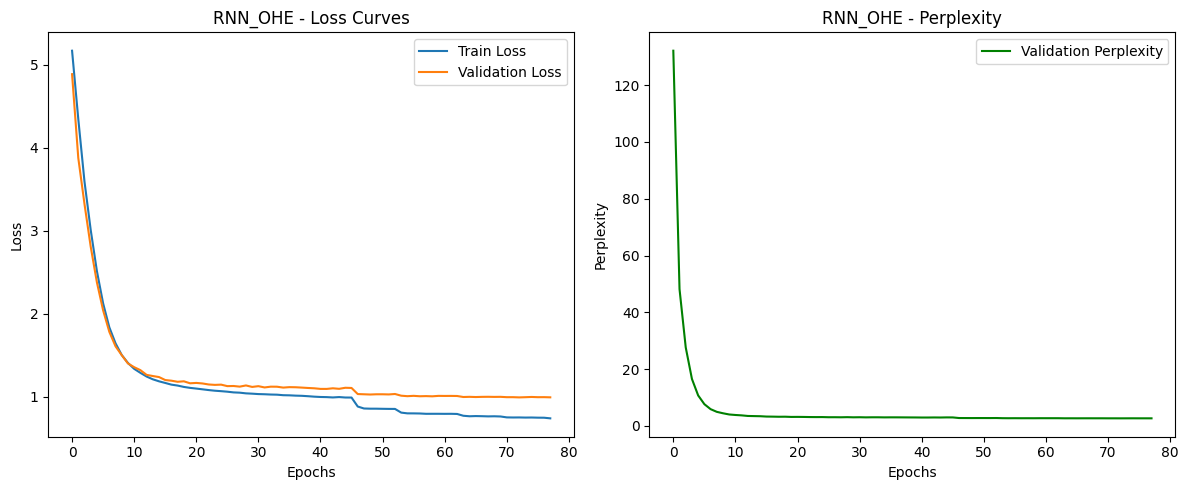

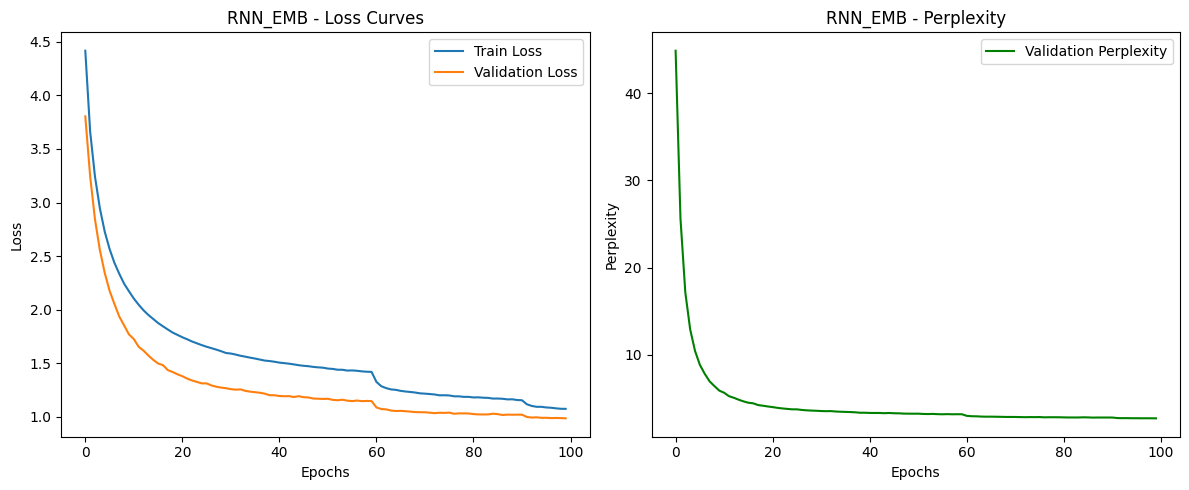

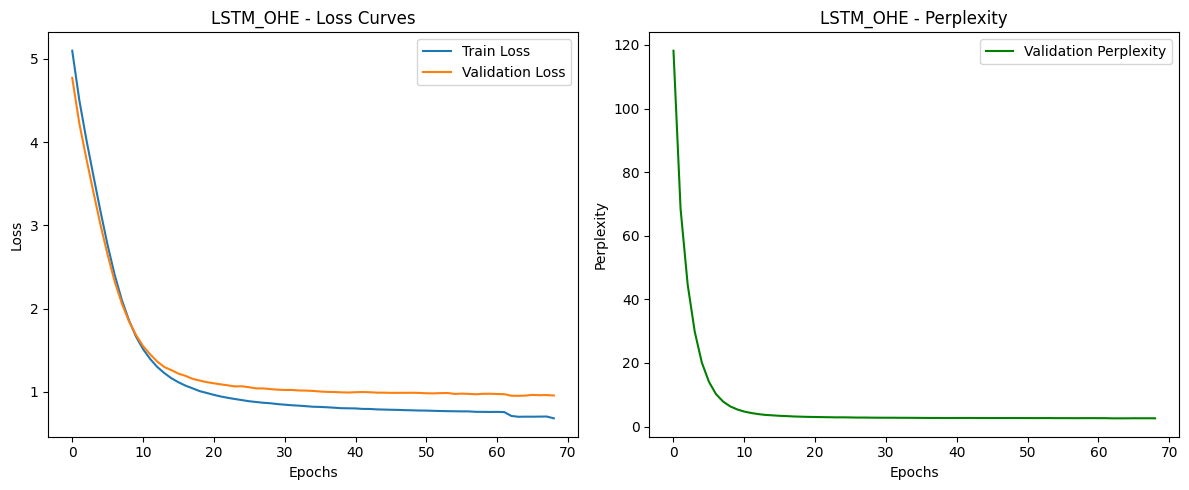

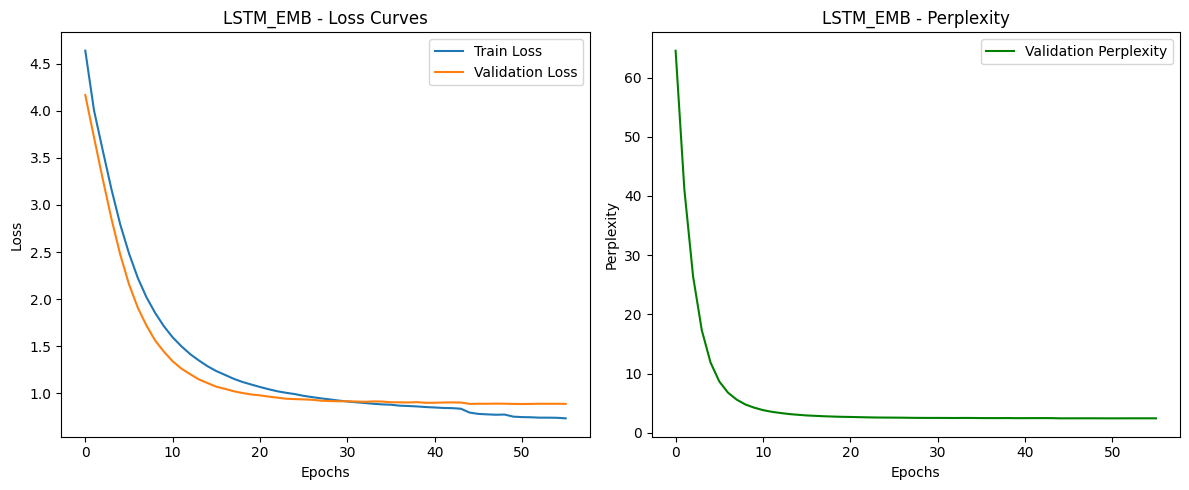

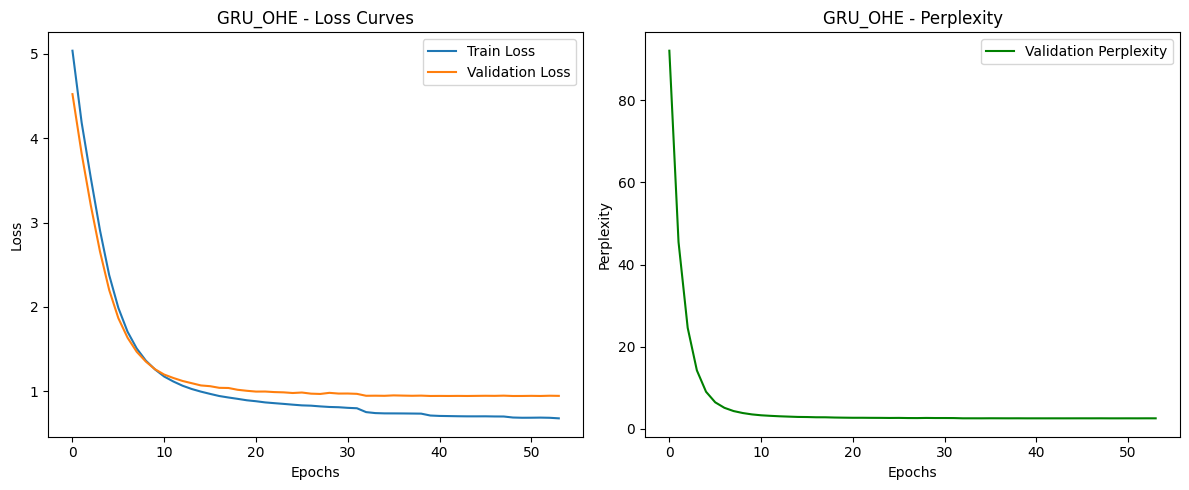

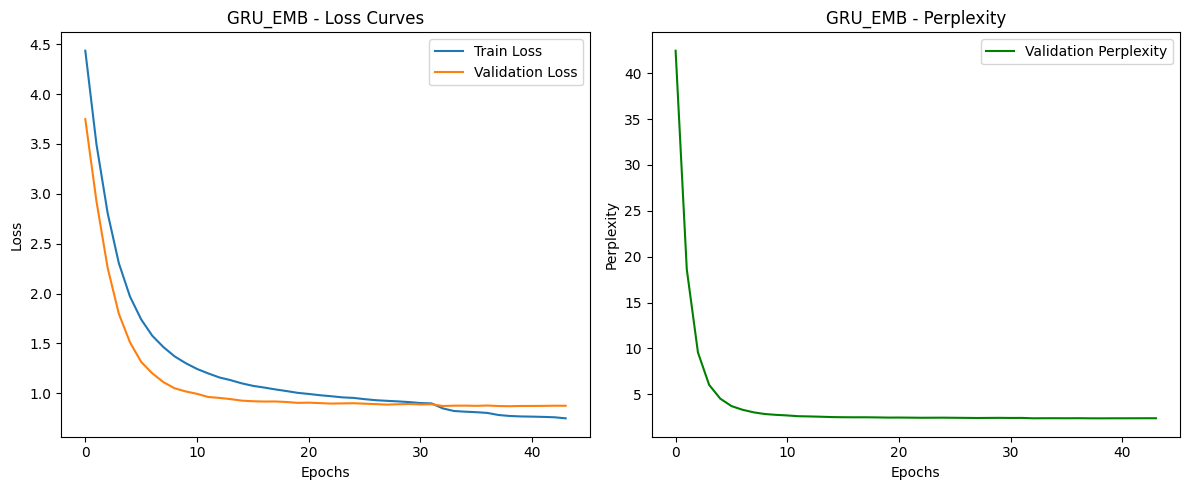

In [29]:

# Initialize all models
models = {
    "RNN_OHE": RNNOneHot(vocab_size, hidden_size, num_layers, dropout).to(device),
    "RNN_EMB": RNNEmbedding(vocab_size, embed_size, hidden_size, num_layers, dropout).to(device),
    "LSTM_OHE": LSTMOneHot(vocab_size, hidden_size, num_layers, dropout).to(device),
    "LSTM_EMB": LSTMEmbedding(vocab_size, embed_size, hidden_size, num_layers, dropout).to(device),
    "GRU_OHE": GRUOneHot(vocab_size, hidden_size, num_layers, dropout).to(device),
    "GRU_EMB": GRUEmbedding(vocab_size, embed_size, hidden_size, num_layers, dropout).to(device)
}

# Loss function
criterion = nn.CrossEntropyLoss(ignore_index=word_to_idx.get('<pad>', 0))

# Train all models
print("\n===== Starting training for all models =====\n")

for model_name, model in models.items():
    print(f"\n===== Training {model_name} =====\n")

    # Setup optimizer and scheduler
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=3, verbose=True)

    # Train the model
    history = train_model(
        model, train_loader, val_loader, criterion, optimizer,
        num_epochs=100, model_name=model_name, scheduler=scheduler,
        patience=5, clip_grad=5.0
    )



===== Evaluating all models =====

Evaluating RNN_OHE...
  Test Loss: 0.9843
  Perplexity: 2.68
  Accuracy: 0.7816
  Sample:
Love Is
so, poor,
by my own hands,
there, the

Evaluating RNN_EMB...
  Test Loss: 0.9995
  Perplexity: 2.72
  Accuracy: 0.7899
  Sample:
Love Is their
to me the beautiful
and summer,
the press of
my foot to the earth springs a
hundred

Evaluating LSTM_OHE...
  Test Loss: 0.9465
  Perplexity: 2.58
  Accuracy: 0.7914
  Sample:
Love Is a

Evaluating LSTM_EMB...
  Test Loss: 0.8912
  Perplexity: 2.44
  Accuracy: 0.8036
  Sample:
Love Is under its ribs,
where
the

Evaluating GRU_OHE...
  Test Loss: 0.9405
  Perplexity: 2.56
  Accuracy: 0.7914
  Sample:
Love Is so

Evaluating GRU_EMB...
  Test Loss: 0.8647
  Perplexity: 2.37
  Accuracy: 0.8095
  Sample:
Love Is so.
sure as
the most certain sure,


===== Final Results Summary =====

Model | Perplexity | Accuracy
----- | ---------- | --------
RNN_OHE | 2.68 | 0.7816
RNN_EMB | 2.72 | 0.7899
LSTM_OHE | 2.58 | 0.7914
LSTM_

'Love Is so.\nsure as\nthe most certain sure,'

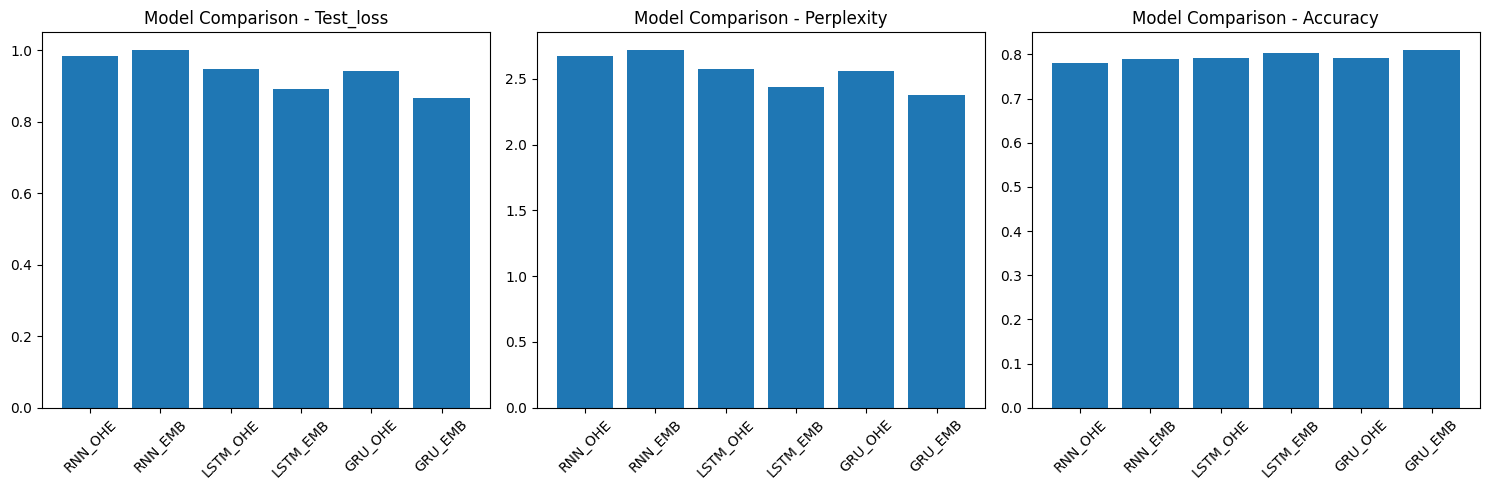

In [36]:

# Evaluate all models
print("\n===== Evaluating all models =====\n")
evaluation_results = evaluate_all_models(models, test_loader, criterion)

# Print final results summary
print("\n===== Final Results Summary =====\n")
print("Model | Perplexity | Accuracy")
print("----- | ---------- | --------")
for model_name, results in evaluation_results.items():
    print(f"{model_name} | {results['perplexity']:.2f} | {results['accuracy']:.4f}")

# Generate poems from the best model
best_model_name = min(evaluation_results,
                      key=lambda x: evaluation_results[x]['perplexity'])
best_model = models[best_model_name]
generate_poem(best_model, word_to_idx, idx_to_word, ["love", "is"])

